# Gradient Boosting for Cambridge UK Weather Forecasting

Gradient boosting models for time series analysis of Cambridge UK temperature measurements taken at the [University computer lab weather station](https://www.cl.cam.ac.uk/research/dtg/weather/).

This notebook is being developed on [Google Colab](https://colab.research.google.com), primarily using [LightGBM](https://lightgbm.readthedocs.io/), [CatBoost](https://catboost.ai/) and the [Darts](https://unit8co.github.io/darts/) time series package.  Initially I was most interested in short term temperature forecasts (less than 2 hours) but now mostly produce results up to 24 hours in the future for comparison with earlier [baselines](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb).

See my previous notebooks, web apps etc:
 * [Cambridge UK temperature forecast python notebooks](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks)
 * [Cambridge UK temperature forecast R models](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
 * [Bayesian optimisation of prophet temperature model](https://github.com/makeyourownmaker/BayesianProphet)
 * [Cambridge University Computer Laboratory weather station R shiny web app](https://github.com/makeyourownmaker/ComLabWeatherShiny)

The linked notebooks, web apps etc contain further details including:
 * data description
 * data cleaning and preparation
 * data exploration

In particular, see the notebooks:
 * [cammet_baselines_2021](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb) including persistent, simple exponential smoothing, Holt Winter's exponential smoothing and vector autoregression
 * [keras_mlp_fcn_resnet_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb), which uses a streamlined version of data preparation from [Tensorflow time series forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)
 * [lstm_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb) with stacked LSTMs, bidirectional LSTMs and ConvLSTM1D networks
 * [cnn_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cnn_time_series.ipynb) with Conv1D, multi-head Conv1D, Conv2D and Inception-style models
 * [encoder_decoder](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/encoder_decoder.ipynb) which includes autoencoder with attention, encoder decoder with teacher forcing, transformer with teacher forcing and padding, encoder only with MultiHeadAttention
 * [tsfresh_feature_engineering](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/tsfresh_feature_engineering.ipynb) automated feature engineering and selection for time series analysis of Cambridge UK weather measurements

Most of the above repositories, notebooks, web apps etc were built on both less data and less thoroughly cleaned data.

---

Install [darts](https://unit8co.github.io/darts/) because it is currently not available on google colab.

**WARNING**: You must restart the google colab runtime after this install.

In [1]:
#!pip install darts
# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.1 which is incompatible.

#!pip install "u8darts[torch]"
# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.1 which is incompatible.

!pip install "u8darts[pmdarima]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.2/592.2 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 9

Load most of the other required packages.

In [1]:
import sys
import math
import datetime
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm
from itertools import product
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random
random.seed(42)
np.random.seed(42)

%matplotlib inline

env: PYTHONHASHSEED=0



### Environment variables

Set some environment variables.

 * `TSFRESH` - include tsfresh features or not



In [2]:
TSFRESH = False
HORIZON = 48
Y_COL   = 'y_des'



## Import ComLab Data

The measurements are relatively noisy and there are usually several hundred missing values every year; often across multiple variables.
Observations have been extensively cleaned but may still have issues.  Interpolation and missing value imputation have been used to fill all missing values.  See the [cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning) in the [Cambridge Temperature Model repository](https://github.com/makeyourownmaker/CambridgeTemperatureModel) for details.  Observations start in August 2008 and end in September 2022 and occur every 30 mins.

**TODO** This code has grown to the point where moving more of it into functions makes sense.

Shape:


(239887, 37)


Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 239887 entries, 2008-08-01 08:30:00 to 2022-09-19 00:00:00
Data columns (total 37 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ds                  239743 non-null  datetime64[ns]
 1   y                   239743 non-null  float64       
 2   y_seasonal          239743 non-null  float64       
 3   y_des               239743 non-null  float64       
 4   y_des_std_6         239739 non-null  float64       
 5   y_des_std_12        239733 non-null  float64       
 6   humidity            239743 non-null  float64       
 7   humidity_seasonal   239743 non-null  float64       
 8   humidity_des        239743 non-null  float64       
 9   pressure            239743 non-null  float64       
 10  dew.point           239743 non-null  float64       
 11  dew.point_seasonal  239743 non-null  float64       
 12  dew.point_des       239743 non-null  float64 

None


Summary stats:


,y,y_seasonal,y_des,y_des_std_6,y_des_std_12,humidity,humidity_seasonal,humidity_des,pressure,dew.point,...,isd_outlier,long_run,spike,cooksd_out,isd_3_sigma,isd_filled,hist_average,mi_filled,mi_spike_interp,lin_interp
count,239743.000000,239743.000000,239743.000000,239739.000000,239733.000000,239743.000000,239743.000000,239743.000000,239743.000000,239743.000000,...,239743.000000,239743.000000,239743.000000,239743.000000,239743.000000,239743.000000,239743.0,239743.0,239743.000000,239743.000000
mean,10.117427,10.176348,-0.058921,3.304033,3.384259,78.163125,78.014168,0.148957,1014.599007,5.979012,...,0.013314,0.010211,0.001272,0.000229,0.000634,0.011546,0.0,0.0,0.000029,0.000029
std,6.521537,5.547079,3.315878,1.152964,0.861957,17.537268,12.826738,11.787218,11.940949,5.165345,...,0.114617,0.100532,0.035645,0.015145,0.025172,0.106829,0.0,0.0,0.005403,0.005403
min,-7.000000,-0.278571,-12.923810,0.206559,0.861146,20.000000,40.571429,-54.533333,963.000000,-10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
25%,5.200000,5.235714,-2.300000,2.464847,2.749325,68.000000,68.380357,-7.342857,1008.000000,2.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
50%,9.600000,9.612143,-0.140179,3.203123,3.324064,82.000000,82.478571,0.214286,1016.000000,6.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
75%,14.500000,14.357143,2.166673,4.042388,3.956780,92.000000,88.357143,7.571429,1023.000000,9.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
max,37.800000,24.817857,13.578571,11.092628,8.986155,100.000000,97.264286,50.533333,1051.000000,20.900000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000



Raw data:


,ds,y,y_seasonal,y_des,y_des_std_6,y_des_std_12,humidity,humidity_seasonal,humidity_des,pressure,...,isd_outlier,long_run,spike,cooksd_out,isd_3_sigma,isd_filled,hist_average,mi_filled,mi_spike_interp,lin_interp
ds,,,,,,,,,,,,,,,,,,,,,
2008-08-01 08:30:00,2008-08-01 08:30:00,18.6,18.086667,0.513333,3.367101,3.606568,69.0,68.800000,0.200000,1010.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-01 09:00:00,2008-08-01 09:00:00,19.1,18.920000,0.180000,3.746681,3.907365,70.0,66.466667,3.533333,1010.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-01 09:30:00,2008-08-01 09:30:00,19.5,19.786667,-0.286667,3.939585,4.044271,68.0,63.933333,4.066667,1010.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-01 10:00:00,2008-08-01 10:00:00,20.0,20.073333,-0.073333,4.362352,4.183206,68.0,59.600000,8.400000,1010.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-01 10:30:00,2008-08-01 10:30:00,21.3,20.600000,0.700000,4.179397,4.153072,61.0,60.200000,0.800000,1010.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-18 22:00:00,2022-09-18 22:00:00,9.2,11.973333,-2.773333,3.741657,2.933957,82.0,85.200000,-3.200000,1024.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-18 22:30:00,2022-09-18 22:30:00,9.2,11.693333,-2.493333,4.060049,3.192736,81.0,85.600000,-4.600000,1024.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-18 23:00:00,2022-09-18 23:00:00,9.2,11.486667,-2.286667,4.060049,3.209113,81.0,84.933333,-3.933333,1024.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


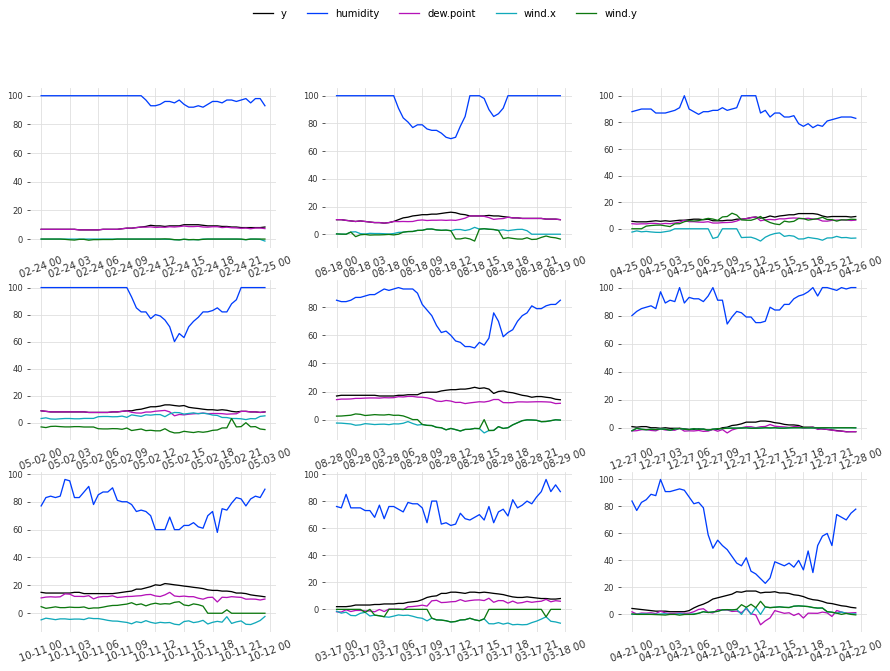

In [48]:
if 'google.colab' in str(get_ipython()):
    data_url = "https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/CamMetCleanishMissAnnotated2022.09.20.csv?raw=true"
else:
    data_url = "../data/CamMetCleanishMissAnnotated2022.09.20.csv"

df = pd.read_csv(data_url, parse_dates=['ds'])
df.set_index('ds', drop=False, inplace=True)
df = df[~df.index.duplicated(keep='first')]
df = df.asfreq(freq='30min')
df_orig = df


# Data reformating - https://www.cl.cam.ac.uk/research/dtg/weather/weather-raw-format.txt
for column in ['temperature', 'dew.point', 'wind.speed.mean']:
    df[column] /= 10

df['y'] = df['temperature']
    
# Deep copy avoids SettingWithCopyWarning
df = df.loc['2008-08-01 00:00:00':'2022-09-19 00:00:00', :].copy(deep=True)


# Convert wind direction and speed to x and y vectors, so the model can more easily interpret them
wv = df['wind.speed.mean']
wd_rad = df['wind.bearing.mean'] * np.pi / 180  # Convert to radians

# Calculate the wind x and y components
df['wind.x'] = wv * np.cos(wd_rad)
df['wind.y'] = wv * np.sin(wd_rad)


# From https://carnotcycle.wordpress.com/2012/08/04/how-to-convert-relative-humidity-to-absolute-humidity/
# Neither ah (absolute humidity) nor rh (relative humidity) proved useful for 
# forecasting but they may have utility for imputation
# See also: https://carnotcycle.wordpress.com/2017/08/01/compute-dewpoint-temperature-from-rh-t/
#           https://carnotcycle.wordpress.com/tag/formula/
# df['rh'] = 100 * (np.exp((18.678 * df['dew.point']) / (257.14 + df['dew.point'])) / np.exp((18.678 * df['y']) / (257.14 + df['y'])))
# df.loc[df['rh'] > 100.0, 'rh'] = 100.0
# df.loc[df['rh'] <  20.0, 'rh'] =  20.0
df['ah'] = 13.24715 * df['humidity'] * (np.exp((17.67 * df['y']) / (243.5 + df['y']))) / (273.15 + df['y'])
df['mixing_ratio'] = 6.112 * 6.2218 * df['humidity'] * np.exp(17.67 * df['y'] / (df['y'] + 243.5)) / \
                     (df['pressure'] - 0.06112 * df['humidity'] * np.exp(17.67 * df['y'] / (df['y'] + 243.5)))


# Convert to secs and add daily and yearly sinusoidal time terms
date_time   = pd.to_datetime(df['ds'], format = '%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

DAY  = 24 * 60 * 60
YEAR = 365.2425 * DAY


def sinusoidal_arg(timestamp_s, denominator):
    return 2 * np.pi * timestamp_s / denominator


# df['day.sin']  = np.sin(sinusoidal_arg(timestamp_s, day))
# df['day.cos']  = np.cos(sinusoidal_arg(timestamp_s, day))
# df['year.sin'] = np.sin(timestamp_s * (2 * np.pi / year))
# df['year.cos'] = np.cos(timestamp_s * (2 * np.pi / year))

#for i in [1, 2, 3]:
#    df['day.sin.'  + str(i)] = np.sin(sinusoidal_arg(timestamp_s, i * day))
#    df['day.cos.'  + str(i)] = np.cos(sinusoidal_arg(timestamp_s, i * day))
#    df['year.sin.' + str(i)] = np.sin(sinusoidal_arg(timestamp_s, i * year))
#    df['year.cos.' + str(i)] = np.cos(sinusoidal_arg(timestamp_s, i * year))

# ps - phase shift
for i, ps in enumerate([0, np.pi], start=1):
    df['day.sin.'  + str(i)] = np.sin(sinusoidal_arg(timestamp_s, DAY)  + ps)
    df['day.cos.'  + str(i)] = np.cos(sinusoidal_arg(timestamp_s, DAY)  + ps)
    df['year.sin.' + str(i)] = np.sin(sinusoidal_arg(timestamp_s, YEAR) + ps)
    df['year.cos.' + str(i)] = np.cos(sinusoidal_arg(timestamp_s, YEAR) + ps)


# Add daily spline-based time terms
from sklearn.preprocessing import SplineTransformer


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree  = degree,
        n_knots = n_knots,
        knots   = np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation = "periodic",
        include_bias  = True,
    )


DAILY_OBS = 48
hour_df = pd.DataFrame(
    np.linspace(0, DAY, DAILY_OBS + 1).reshape(-1, 1),
    columns=["secs"],
)

YEARLY_OBS = int(365.2425 * DAILY_OBS)  # annual observations
month_df = pd.DataFrame(
    np.linspace(0, YEAR, YEARLY_OBS + 1).reshape(-1, 1),
    columns=["secs"],
)

# 12 splines approximating 12 month-like time components
day_splines = periodic_spline_transformer(DAY, n_splines=12).fit_transform(hour_df)
day_splines_df = pd.DataFrame(
    day_splines,
    columns=[f"day_spline_{i}" for i in range(day_splines.shape[1])],
)
DAY_SECS_STEP = int(DAY / DAILY_OBS)
day_splines_df['secs_since_midnight'] = range(0, DAY + DAY_SECS_STEP, DAY_SECS_STEP)

# pd.concat([hour_df, day_splines_df], axis="columns").plot(x="secs", cmap=plt.cm.tab20b)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

year_splines = periodic_spline_transformer(YEAR, n_splines=12).fit_transform(month_df)
year_splines_df = pd.DataFrame(
    year_splines,
    columns=[f"year_spline_{i}" for i in range(year_splines.shape[1])],
)
year_splines_df['secs_elapsed'] = range(0, int(YEAR), DAY_SECS_STEP)



# Add seasonal mean temperature (y_seasonal), humidity and dew.point
df['secs_since_midnight'] = ((df['ds'] - df['ds'].dt.normalize()) / pd.Timedelta('1 second')).astype(int)
df['doy'] = df['ds'].apply(lambda x: x.dayofyear - 1)
df['secs_elapsed'] = df['secs_since_midnight'] + df['doy'] * DAY

for var in ['y', 'humidity', 'dew.point']:
  df_seasonal_var = df[[var, 'secs_elapsed']].groupby('secs_elapsed').mean(var)
  df_seasonal_var.rename(columns={var: var + '_seasonal'}, inplace=True)
  df = pd.merge(df, df_seasonal_var,   on='secs_elapsed')
  df[var + '_des'] = df[var] - df[var + '_seasonal']  # des - deseasonal

df = pd.merge(df, day_splines_df,  on='secs_since_midnight')
df = pd.merge(df, year_splines_df, on='secs_elapsed')


# Add lagged mean and/or std devs
# for var in ['y_des', 'humidity_des', 'pressure', 'dew.point_des', 'wind.x', 'wind.y']:
for var in ['y_des']:
  for win in [6, 12]:
    df[var + '_mean_' + str(win)] = df[var].rolling(window=win).mean()
    df[var + '_std_'  + str(win)] = df[var].rolling(window=win).std()


# Add Boruta-style "shadow" variables for feature selection
for var in ['y', 'humidity', 'pressure', 'dew.point', 'wind.x', 'wind.y']:
    df[var + '_shadow'] = np.random.permutation(df[var])


df.set_index('ds', drop=False, inplace=True)
df = df.asfreq(freq='30min')


# Reorder and drop temporary calculation columns
cols = ['ds', 'y', 'y_seasonal', 'y_des',  \
        'humidity', 'humidity_seasonal', 'humidity_des', 'pressure', \
        'dew.point', 'dew.point_seasonal', 'dew.point_des', 'wind.x', 'wind.y', \
        #'mixing_ratio', 'ah', \
        'day.sin.1', 'day.cos.1', 'year.sin.1', 'year.cos.1', \
        #'day.sin.2', 'day.cos.2', 'year.sin.2', 'year.cos.2', \
        #'day.sin.3', 'day.cos.3', 'year.sin.3', 'year.cos.3', \
        'y_shadow', 'humidity_shadow', 'pressure_shadow', \
        'dew.point_shadow', 'wind.x_shadow', 'wind.y_shadow', \
        #'day_spline_0', 'day_spline_1', 'day_spline_2', 'day_spline_3', \
        #'day_spline_4', 'day_spline_5',  'day_spline_6', 'day_spline_7', \
        #'day_spline_8', 'day_spline_9', 'day_spline_10', 'day_spline_11', \
        #'year_spline_0', 'year_spline_1', 'year_spline_2', 'year_spline_3', \
        #'year_spline_4', 'year_spline_5',  'year_spline_6', 'year_spline_7', \
        #'year_spline_8', 'year_spline_9', 'year_spline_10', 'year_spline_11', \
        'missing', 'known_inaccuracy', 'isd_outlier', 'long_run', 'spike', \
        'cooksd_out', 'isd_3_sigma', 'isd_filled', 'hist_average', \
        'mi_filled', 'mi_spike_interp', 'lin_interp']
df = df[cols]

# df = df.loc[df['missing'] == 0.0, :]
df = df.loc[(df['mi_filled'] != 1.0) & (df['hist_average'] != 1.0), :]

# For use in other notebooks
if not 'google.colab' in str(get_ipython()):
    data_loc = "../data/CamMetPrepped2022.09.20.csv"
    df.to_csv(data_loc)


print("Shape:")
display(df.shape)
print("\nInfo:")
display(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
display(df)
print("\n")


def plot_observation_examples(data, cols):
    """Plot 9 sets of observations in 3 * 3 matrix"""

    assert len(data) == 9

    fig, axs = plt.subplots(3, 3, figsize = (15, 10))
    axs = axs.ravel()  # apl for the win :-)

    for i in range(9):
        for col in cols:
            axs[i].plot(data[i]['ds'], data[i][col])
            axs[i].xaxis.set_tick_params(rotation = 20, labelsize = 10)
    
    fig.legend(cols, loc = 'upper center',  ncol = len(cols))
    
    return None


num_plots = 9
days = df.ds.dt.date.sample(n = num_plots).sort_values()
p_data = [df[df.ds.dt.date.eq(days[i])] for i in range(num_plots)]
cols   = ['y', 'humidity', 'dew.point', 'wind.x', 'wind.y']  # 'pressure',    

plot_observation_examples(p_data, cols)

I didn't include `pressure` in example observation plots because those values are an order of magnitude higher than the other features.  

A few other things to note:
 * features which did not prove useful this time
    * absolute humidity
    * mixing ratio
    * spline-based time components
    * higher frequency sinusoidal time components
    * phase-shifted sinusoidal time components
    * I leave the code for generating these features incase it is useful later
       * for example with the inclusion of the rainfall feature
 * the temperature, `y`, has been deseasonalised giving `y_des`
 * I have excluded the `mi_filled` and `hist_average` imputed values
    * `mi_filled` - multiple imputation
    * `hist_average` - historic average
    * some of these values were very poor imputations
    * none of the other missing observation features were selected


#### Calculate solar irradiance

[Solar irradiance](https://en.wikipedia.org/wiki/Solar_irradiance) is the power per unit area (surface power density) received from the Sun.  Irradiance plays a part in weather forecasting.  I calculate solar irradiance for Cambridge using the python [solarpy](https://github.com/aqreed/solarpy) module.  I suspect forecasts could be substantially improved if solar irradiance could be combined with a measure of cloud cover.  It could also be used as a future covariate with models built with the darts package.

Solar irradiance calculation:
  * just calculate irradiance for a single year (arbitrarily 2020)
  * then repeat values for the other years
  * **TODO** integrate into main data transformations above

In [49]:
import sys
import subprocess
import pkg_resources


required  = {'solarpy'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing   = required - installed
# print("missing:", missing)

# if missing:
if missing == required:
    print("Installing ", missing, sep=' ')
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing])  #, stdout=subprocess.DEVNULL)
    print("Done")


from solarpy import irradiance_on_plane


HEIGHT = 6  # height above sea level
LAT    = 52.210922
VNORM  = np.array([0, 0, -1])  # plane pointing zenith
irradiances = list()

df['year'] = df['ds'].dt.year
irr_df = pd.DataFrame()
irr_df.index = df.loc[df['year'] == 2020, 'ds']
irr_df.index = pd.to_datetime(irr_df.index)

for d in tqdm(irr_df.index, desc='Calculating irradiance'):
    irradiance = irradiance_on_plane(VNORM, HEIGHT, d, LAT)
    irradiances.append(irradiance)

irr_df['irradiance'] = irradiances
# irr_df['irradiance'].describe()

irr_df['month']  = irr_df.index.month
irr_df['day']    = irr_df.index.day
irr_df['hour']   = irr_df.index.hour
irr_df['minute'] = irr_df.index.minute

df['month']  = df.index.month
df['day']    = df.index.day
df['hour']   = df.index.hour
df['minute'] = df.index.minute

df = df.merge(irr_df, on=['month','day','hour','minute'])
df.set_index('ds', drop=False, inplace=True)
df = df[~df.index.duplicated(keep='first')]
df = df.asfreq(freq='30min')
df.drop(['month','day','hour','minute'], inplace=True, axis=1)
df['irradiance'].describe()

Installing  {'solarpy'}
Done


Calculating irradiance: 100%|██████████| 17338/17338 [00:03<00:00, 4496.68it/s]


count    236948.000000
mean        144.590234
std         227.286088
min           0.000000
25%           0.000000
50%           0.002045
75%         224.316841
max         805.382014
Name: irradiance, dtype: float64

There is zero solar irradiance at night.  Hence the near zero median value for irradiance.

---

### Import tsfresh features

[tsfresh](https://tsfresh.readthedocs.io/en/latest/) features were generated and filtered in [this notebook]().  [Here](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html) is a list of the features extracted by tsfresh.

Features were generated for:
 * individual observations
   * no data leakage concerns so generated features are saved in a single file
 * rolling observations with window size of 50
   * 48 + 2 to capture all lagged features from the previous 24 hours
   * data leakage concerns mean features are generated and saved in 3 files
     * training data
     * validation data
     * testing data

The rolling window features are loaded after the data is split into train, valid and test sets.

First, load the individual observations features and merge with existing data:

In [ ]:
if TSFRESH:
    if 'google.colab' in str(get_ipython()):
        tsf_url = "https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/tsfresh.2022.09.20.csv.xz?raw=true"
    else:
        tsf_url = "../data/tsfresh.2022.09.20.csv.xz"


    tsf = pd.read_csv(tsf_url, compression='xz', parse_dates=['ds'])
    tsf.set_index('ds', drop=True, inplace=True)
    # tsf = tsf.asfreq(freq='30min')

    print("tsf:")
    print(tsf.info())
    print(tsf.columns, "\n")
    print("df:")
    print(df.info(), "\n")

    df = pd.merge(df, tsf, left_index=True, right_index=True)

    df.set_index('ds', drop=False, inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    df = df.asfreq(freq='30min')
    df.drop('ds.1', axis=1, inplace=True)
    print("df:")
    print(df.info())

Ultimately, the tsfresh features did not prove useful.  I leave the tsfresh import code here for possible future experiments.

---

### Split data¶

I use data from 2018 for validation, 2019 for testing and the remaining data for training. These are entirely arbitrary choices. This results in an approximate 88%, 6%, 6% split for the training, validation, and test sets respectively.

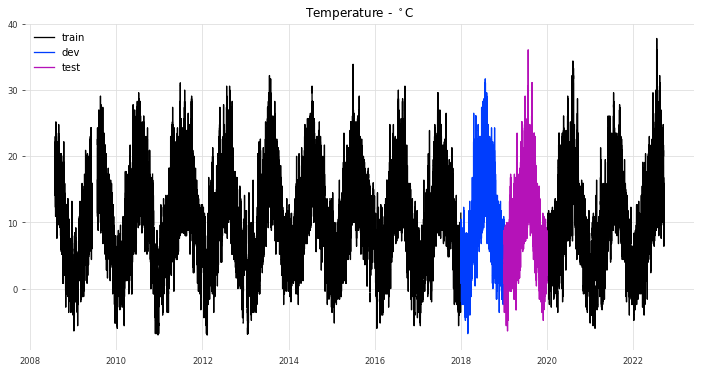

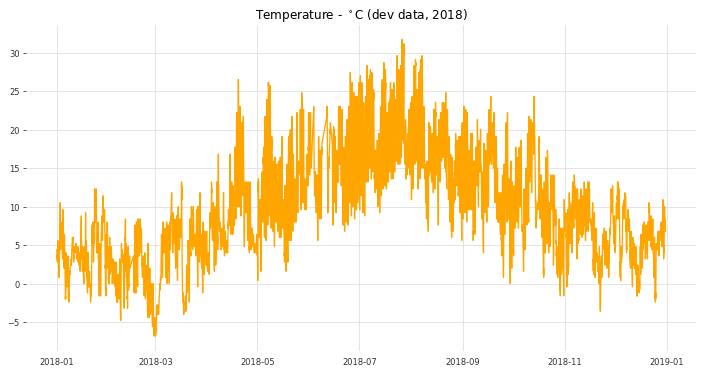

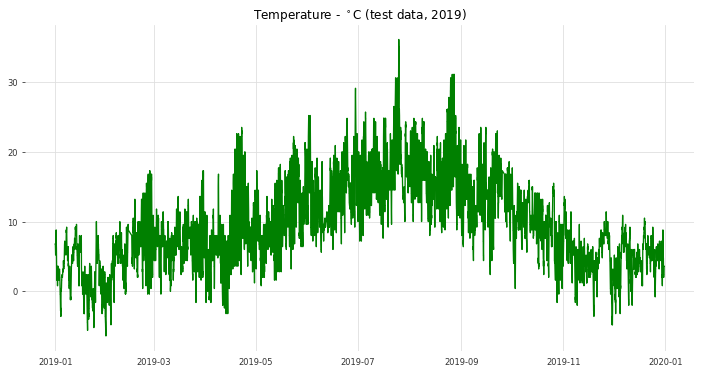

df.drop shape:  (247760, 38)
train shape:    (247760, 37)
valid shape:    (17484, 37)
test shape:     (17484, 37)


In [50]:
# df['year'] = df['ds'].dt.year
train_df = df.loc[(df['year'] != 2018) & (df['year'] != 2019)]
# train_df = df.loc[(df['year'] == 2015) | (df['year'] == 2016) | (df['year'] == 2017)]
# train_df = df.loc[(df['year'] == 2016) | (df['year'] == 2017)]
# train_df = df.loc[df['year'] <= 2017]
# train_df = df.loc[df['year'] == 2016]
valid_df = df.loc[df['year'] == 2018]
test_df  = df.loc[df['year'] == 2019]


plt.figure(figsize = (12, 6))
plt.plot(train_df.ds, train_df.y)
plt.plot(valid_df.ds, valid_df.y)
plt.plot(test_df.ds,  test_df.y)
plt.title('Temperature - $^\circ$C')
plt.legend(['train', 'dev', 'test'])
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(valid_df.ds, valid_df.y, color='orange')
plt.title('Temperature - $^\circ$C (dev data, 2018)')
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(test_df.ds, test_df.y, color='green')
plt.title('Temperature - $^\circ$C (test data, 2019)')
plt.show()


del_cols = ['ds', 'year']
train_df = train_df.drop(del_cols, axis = 1)
valid_df = valid_df.drop(del_cols, axis = 1)
test_df  = test_df.drop(del_cols,  axis = 1)
df = df.drop(['year'], axis = 1)

# DO NOT USE ffill with train_df - ffills 2018 & 2019!
# train_df = train_df.asfreq(freq='30min', method='ffill')
train_df = train_df.asfreq(freq='30min')

# DO USE ffill with valid_df, test_df
# avoids missing value errors when calculating metrics etc
valid_df = valid_df.asfreq(freq='30min')
test_df  =  test_df.asfreq(freq='30min')
# valid_df = valid_df.asfreq(freq='30min', method='ffill')
# test_df  =  test_df.asfreq(freq='30min', method='ffill')


print("df.drop shape: ", df.shape)
print("train shape:   ", train_df.shape)
print("valid shape:   ", valid_df.shape)
print("test shape:    ", test_df.shape)

Calculate some correlations:

In [38]:
for var in ['y', 'dew.point', 'humidity']:
  ws = '\t\t' if len(var) < 7 else '\t'
  print(var, '-', var, '_seasonal', ws, df[var].corr(df[var + '_seasonal']), sep='')

print()
for var in ['y', 'dew.point', 'humidity']:
  sep = '\t\t' if len(var) < 7 else '\t'
  print(var, '- y_des', ws, df[var + '_des'].corr(df['y_des']), sep='')

y 		 0.861288549299876
dew.point 	 0.7499746891096526
humidity 	 0.7407273379876674

y 		 1.0
dew.point 	 0.6774750495007185
humidity 	 -0.32207130938918516


...

Plot correlations as a hierarchically clustered heatmap:

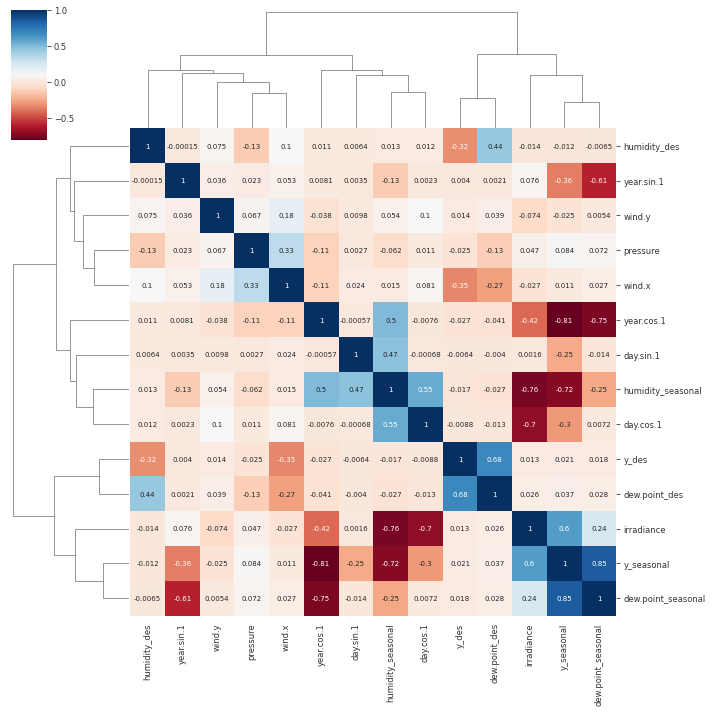

In [39]:
df_red = df[['y_des', 'y_seasonal', 'humidity_des', 'humidity_seasonal', \
             'pressure', 'dew.point_des', 'dew.point_seasonal', \
             'wind.x', 'wind.y', \
             'irradiance', 'day.sin.1', 'day.cos.1', 'year.sin.1', 'year.cos.1']]

sns.clustermap(df_red.corr(), method="complete", cmap='RdBu', annot=True, annot_kws={"size": 7});

...

Plot various distributions:

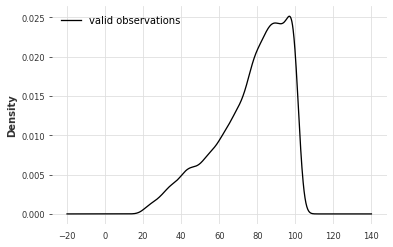

In [ ]:
col_name = 'humidity'
#df[col_name].plot(kind = 'density', label='all observations')
#train_df[col_name].plot(kind = 'density', label='train observations')
valid_df[col_name].plot(kind = 'density', label='valid observations')
#test_df[col_name].plot(kind = 'density', label='test observations')
#plt.xlim(-15, 15)
plt.legend()
plt.show()

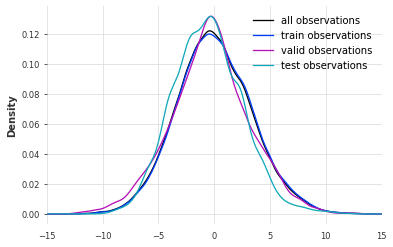

In [ ]:
df['y_des'].plot(kind = 'density', label='all observations')
train_df['y_des'].plot(kind = 'density', label='train observations')
valid_df['y_des'].plot(kind = 'density', label='valid observations')
test_df['y_des'].plot(kind = 'density', label='test observations')
plt.xlim(-15, 15)
plt.legend()
plt.show()

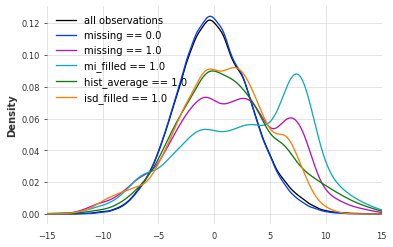

In [ ]:
df['y_des'].plot(kind = 'density', label='all observations')
df.loc[df['missing'] == 0.0, 'y_des'].plot(kind = 'density', label='missing == 0.0')
df.loc[df['missing'] == 1.0, 'y_des'].plot(kind = 'density', label='missing == 1.0')
df.loc[df['mi_filled'] == 1.0, 'y_des'].plot(kind = 'density', label='mi_filled == 1.0')
df.loc[df['hist_average'] == 1.0, 'y_des'].plot(kind = 'density', label='hist_average == 1.0')
df.loc[df['isd_filled'] == 1.0, 'y_des'].plot(kind = 'density', label='isd_filled == 1.0')
plt.xlim(-15, 15)
plt.legend()
plt.show()

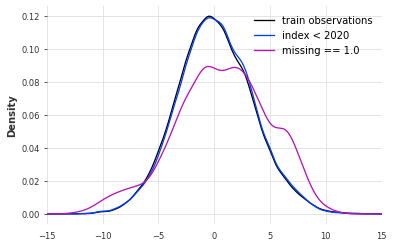

In [ ]:
#df['y_des'].plot(kind = 'density', label='all observations')
#df.loc[df['missing'] == 0.0, 'y_des'].plot(kind = 'density', label='missing == 0.0')
#df.loc[df['missing'] == 1.0, 'y_des'].plot(kind = 'density', label='missing == 1.0')
#df.loc[df['mi_filled'] == 1.0, 'y_des'].plot(kind = 'density', label='mi_filled == 1.0')
#df.loc[df['hist_average'] == 1.0, 'y_des'].plot(kind = 'density', label='hist_average == 1.0')
#df.loc[df['isd_filled'] == 1.0, 'y_des'].plot(kind = 'density', label='isd_filled == 1.0')
train_df['y_des'].plot(kind = 'density', label='train observations')
train_df.loc[train_df.index < '2020', 'y_des'].plot(kind = 'density', label='index < 2020')
train_df.loc[train_df['isd_filled'] == 1.0, 'y_des'].plot(kind = 'density', label='missing == 1.0')
#valid_df['y_des'].plot(kind = 'density', label='valid observations')
#test_df['y_des'].plot(kind = 'density', label='test observations')
plt.xlim(-15, 15)
plt.legend()
plt.show()

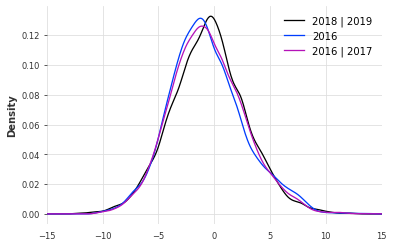

In [ ]:
df['year'] = df['ds'].dt.year

#valid_df['y_des'].plot(kind = 'density', label='valid observations')
#test_df['y_des'].plot(kind = 'density', label='test observations')
#train_df['y_des'].plot(kind = 'density', label='train observations')
# year = '2020'
# train_df.loc[year, 'y_des'].plot(kind = 'density', label=year)
#train_df.loc[(train_df.index == '2016') | (train_df.index == '2017'), 'y_des'].plot(kind = 'density', label=year)
df.loc[(df['year'] == 2018) | (df['year'] == 2019), 'y_des'].plot(kind = 'density', label='2018 | 2019')
df.loc[df['year'] == 2016, 'y_des'].plot(kind = 'density', label='2016')
#df.loc[df['year'] == 2017, 'y_des'].plot(kind = 'density', label='2017')
year = 2008
#df.loc[df['year'] == year, 'y_des'].plot(kind = 'density', label=year)
df.loc[(df['year'] == 2016) | (df['year'] == 2017), 'y_des'].plot(kind = 'density', label='2016 | 2017')
plt.xlim(-15, 15)
plt.legend()
plt.show()

(1000, 2)

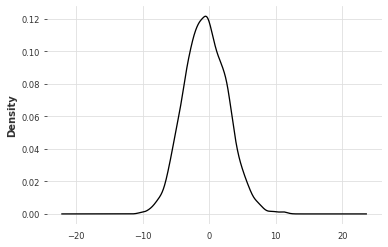

In [ ]:
df.loc[df['year'] == 2017, 'y_des'].plot.kde().get_lines()[0].get_xydata().shape


...

---

Now, load the rolling window tsfresh features and merge with existing data: 


In [ ]:
def read_and_merge_tsfresh_features(df, ds, window=HORIZON):
    fn = 'tsfresh_' + str(window) + 'ish_' + ds + '.2022.09.20.csv.xz'

    if 'google.colab' in str(get_ipython()):
        tsf_url = 'https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/' + fn + '?raw=true'
    else:
        tsf_url = '../data/' + fn

    tsf = pd.read_csv(tsf_url, compression='xz', parse_dates=['ds'])


    # print("\n", ds)
    # print("tsf:", tsf.shape)
    tsf.set_index('ds', drop=False, inplace=True)
    tsf = tsf[~tsf.index.duplicated(keep='first')]
    tsf = tsf.asfreq(freq='30min')

    print("\n", ds)
    print("tsf:", tsf.shape)
    print("df: ", df.shape)

    df = pd.merge(df, tsf, left_index=True, right_index=True)

    df.set_index('ds', drop=True, inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    df = df.asfreq(freq='30min')
    print("merged df:", df.shape)

    return df


if TSFRESH:
    train_df = read_and_merge_tsfresh_features(train_df, 'train')
    valid_df = read_and_merge_tsfresh_features(valid_df, 'valid')
    test_df  = read_and_merge_tsfresh_features(test_df,  'test')

Ultimately, the tsfresh features did not prove useful.  I leave the tsfresh import code here for possible future experiments.

---

### Normalise data

Features do not need to be scaled for gradient boosting methods. Nonetheless, it can often be a
useful sanity check.

The [violin plot](https://en.wikipedia.org/wiki/Violin_plot) shows the distribution of features.

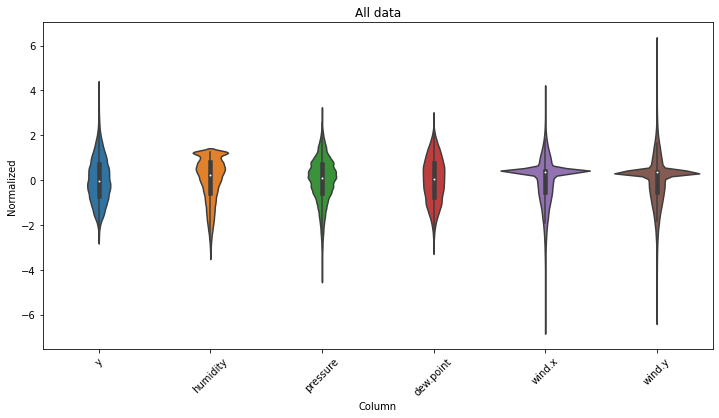

In [ ]:
def inv_transform(scaler, data, colName, colNames):
    """An inverse scaler for use in model validation section

    For later use in plot_forecasts, plot_horizon_metrics and check_residuals
    
    See https://stackoverflow.com/a/62170887/100129"""

    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    
    return dummy[colName].values


cols = ['y', 'humidity', 'pressure', 'dew.point', 'wind.x', 'wind.y']
train_df_norm = train_df.loc[:, cols]
scaler = StandardScaler()
scaler.fit(train_df_norm)

train_df_norm = scaler.transform(train_df_norm)
# valid_df[valid_df.columns] = scaler.transform(valid_df[valid_df.columns] )
# test_df[test_df.columns]   = scaler.transform(test_df[test_df.columns] )

#df_std = scaler.transform(df)
df_std = pd.DataFrame(train_df_norm)
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data = df_std)
ax.set_xticklabels(cols, rotation = 45)
ax.set_title('All data');

Some features have long tails but there are no glaring errors.


---

## Gradient Boosted Model Building

[Gradient boosted models](https://en.wikipedia.org/wiki/Gradient_boosting)  train an ensemble of weak prediction models, which are usually decision trees.  The ensemble model is iteratively built from weak learners and are added to produce a final strong learner.
Successive weak learners focus more on the examples that previous weak learners got wrong.  Historically, gradient boosted models have performed well in the [Kaggle](https://www.kaggle.com/) competitions.  The majority of [M5 forecasting accuracy competition entries used gradient boosted trees](https://www.sciencedirect.com/science/article/pii/S0169207021001874), specifically lightGBM.  See also, [Forecasting with trees](https://www.sciencedirect.com/science/article/pii/S0169207021001679) for more on the M5 competition and the dominance of boosted tree methods.  However, tree-based models may be unable to learn a trend and forecast outside the bounds of the training data.  This should not be a big problem with this cyclical data set.

Even simple lag-based feature engineering for [multi-variate time series multi-step forecasting](https://machinelearningmastery.com/how-to-develop-machine-learning-models-for-multivariate-multi-step-air-pollution-time-series-forecasting/) requires a considerable amount of effort, so a time series framework is beneficial.
I had hoped to use the [skforecast](https://joaquinamatrodrigo.github.io/skforecast/) framework.  Unfortunately, as of the current version (0.5.0) it does not support forecasts with multivariate data.  

The [sktime](https://www.sktime.org/en/stable/index.html) package supports boosting methods via their sklearn compatible [make_reduction](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.compose.make_reduction.html) function.  Initially it gave very poor results for the boosting methods I tried and the `make_reduction` function seemed to be somewhat of a second class option.  In it's defence, it has built in support for [tsfresh](https://www.sktime.org/en/latest/api_reference/auto_generated/sktime.transformations.panel.tsfresh.TSFreshFeatureExtractor.html) and [catch22](https://www.sktime.org/en/latest/api_reference/auto_generated/sktime.transformations.panel.catch22.Catch22.html) feature extraction plus [conformal interval](https://www.sktime.org/en/latest/api_reference/auto_generated/sktime.forecasting.conformal.ConformalIntervals.html) functionality among many other interesting features.

The [darts](https://unit8co.github.io/darts/) package is focused on time series forecasting but can also be used for filtering.

darts time series package:
  * pros
    * supports multi-variate data
    * allows custom lag selection
    * future covariates which many of the other time series packages do not support
  * cons
    * no integrated xgboost support but can use sklearn compatible [RegressionModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html)
    * random forest (from sklearn) implementation is slow
    * deep learning models *currently* don't install on google colab

The following are a few points I consider when building these gradient boosted models.

Forecast horizons:
  * next 24 hours - 48 30 min steps ahead

Metrics:
 * mse - mean squared error
   * mse used for loss function to avoid potential problems with infinite values from the square root function
   * rmse - root mean squared error is used for comparison with baselines
   * Huber loss may be worth exploring in the future if outliers remain an issue
 * mae - median absolute error
 * mape - mean absolute percentage error 
   * Not used - mape fails when values, like temperature, become zero



Parameters to consider optimising:
 * lags
 * exogenous variables
   * time component representations
     * sinusoidal
     * [periodic spline features](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#periodic-spline-features)
  * [tsfresh](https://tsfresh.readthedocs.io/en/latest/) feature extraction
 * hyperparameters
```
param_grid = {
    'n_estimators':  [100, 500],
    'max_depth':     [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
```


Models considered:
   
 1. [darts lightgbm](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.gradient_boosted_model.html)
   * [lightgbm](https://lightgbm.readthedocs.io/)
   * from Microsoft
   * annecdotally, seems quite speedy
   * feature selection
     * using Boruta-style shadow variables
   * lag selection
     1. grid search across `lags` and `lags_past_covariates`
     2. lag addition for target `lags` holding `lags_past_covariates` constant
     3. lag elimination for `lags_past_covariates` holding `lags` constant

 2. [darts catboost](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.catboost_model.html)
   * [catboost](https://catboost.ai/)
   * from Yandex
   * annecdotally, seems more accurate on this data set
   * lag selection
     * starting with some of the best lightgbm lag selection options
   * hyperparameter optimisation
     * grid search

 3. [darts rf](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.random_forest.html)
   * unfortunately this was too slow
     * I stopped the process when eta exceeded 2 hours for a single small model
     * I removed this work from the notebook for brevity


---


Start by loading the required darts imports:

In [19]:
from scipy import stats

from darts.models.forecasting.catboost_model import CatBoostModel
from darts.models.forecasting.lgbm import LightGBMModel

from darts import TimeSeries
from darts.metrics import rmse, mae

import lightgbm as lgb

Next, some utility functions:
 * `rmse_`
 * `mse_`
 * `mae_`
 * `expand_grid`
 * `calculate_historic_comparison`
 * `summarise_hist_comp`
 * `calculate_rmse_mae_from_backtest`
 * `get_most_important_variables`
 * `plot_importances`
 * `plot_obs_vs_preds`
 * `plot_obs_preds_dists`
 * `plot_residuals`
 * `plot_residuals_vs_predicted` - unused?
 * `plot_residuals_dist`
 * `plot_horizon_metrics`
 * `plot_forecast_examples`
 * `plot_learning_curve`


In [20]:
from statsmodels.nonparametric.smoothers_lowess import lowess


def _check_obs_preds_lens_eq(obs, preds):
    obs_preds_lens_eq = 1

    if len(obs) != len(preds):
        print("obs:  ", len(obs))
        print("preds:", len(preds))
        obs_preds_lens_eq = 0

    return obs_preds_lens_eq


def rmse_(obs, preds):
    if _check_obs_preds_lens_eq(obs, preds) == 0:
        stop()
    else:
        return np.sqrt(np.mean((obs - preds) ** 2))


def mse_(obs, preds):
    if _check_obs_preds_lens_eq(obs, preds) == 0:
        stop()
    else:
        return np.mean((obs - preds) ** 2)


def mae_(obs, preds):
    "mean absolute error - equivalent to the keras loss function"
    if _check_obs_preds_lens_eq(obs, preds) == 0:
        stop()
    else:
        return np.mean(np.abs(obs - preds))      # keras loss
        # return np.median(np.abs(obs - preds))  # earlier baselines


def summarise_backtest(backtest, df, horizon = HORIZON, digits = 6, y_col = Y_COL):

    if len(backtest[0]) == 1:
        print("\n# Backtest RMSE:", round(rmse_(val_ser[-len(backtest):].values(), backtest.values()), digits))
        print("# Backtest MAE: ",   round( mae_(val_ser[-len(backtest):].values(), backtest.values()), digits))
        
        print("\nbacktest[", y_col, "]:\n", sep='')
        backtest_stats = stats.describe(backtest[y_col].values())
        print("count\t", backtest_stats[0])
        print("mean\t",  round(backtest_stats[2][0], digits))
        print("std\t",   round(np.sqrt(backtest_stats[3][0]), digits))
        print("min\t",   round(np.min(backtest_stats[1]), digits))
        print("25%\t",   round(np.percentile(backtest[y_col].values(), 25), digits))
        print("50%\t",   round(np.median(backtest[y_col].values()), digits))
        print("75%\t",   round(np.percentile(backtest[y_col].values(), 75), digits))
        print("max\t",   round(np.max(backtest_stats[1]), digits))
    elif len(backtest[0]) == horizon:
        preds_df = pd.concat([backtest[i].pd_dataframe() for i in range(len(backtest))], axis=0)
        trues_df = df.loc[preds_df.index, [y_col]]
        hist_comp = pd.concat([trues_df, preds_df[y_col]], axis = 1)
        hist_comp.columns = [y_col, 'pred']
        list_int = [i for i in range(1, horizon + 1)]
        reps = len(hist_comp) // len(list_int)
        hist_comp['step'] = np.tile(list_int, reps)

        print("\nBacktest RMSE all:", round(rmse_(hist_comp[y_col], hist_comp['pred']), digits))
        print("Backtest MAE all: ",    round(mae_(hist_comp[y_col], hist_comp['pred']), digits))

        print("\n# Backtest RMSE 48th:", round(rmse_(hist_comp.loc[hist_comp['step'] == horizon, y_col], \
                                                     hist_comp.loc[hist_comp['step'] == horizon, 'pred']), digits))
        print("# Backtest MAE 48th: ",    round(mae_(hist_comp.loc[hist_comp['step'] == horizon, y_col], \
                                                     hist_comp.loc[hist_comp['step'] == horizon, 'pred']), digits))

        lasttest_stats = stats.describe(hist_comp['pred'])
        print("\nbacktest[", y_col, "]:\n", sep='')
        print("count\t", len(hist_comp['pred']))
        print("mean\t",  round(lasttest_stats[2], digits))
        print("std\t",   round(np.sqrt(lasttest_stats[3]), digits))
        print("min\t",   round(np.min(lasttest_stats[1]), digits))
        print("25%\t",   round(np.percentile(hist_comp['pred'], 25), digits))
        print("50%\t",   round(np.median(hist_comp['pred']), digits))
        print("75%\t",   round(np.percentile(hist_comp['pred'], 75), digits))
        print("max\t",   round(np.max(lasttest_stats[1]), digits))


def print_rmse_mae(obs, preds, postfix_str, prefix_str = '', digits = 6):
    print(prefix_str, "Backtest RMSE ", postfix_str, ": ",  
          round(rmse_(obs, preds), digits),
          sep='')
    print(prefix_str, "Backtest MAE ",  postfix_str, ":  ", 
          round( mae_(obs, preds), digits),
          sep='')
    print()


def summarise_hist_comp(hc, df, horizon = HORIZON, digits = 6, y_col = Y_COL):

    print_rmse_mae(hc[y_col], hc['pred'], 'all')

    obs   = hc.loc[hc['step'] == horizon, y_col]
    preds = hc.loc[hc['step'] == horizon, 'pred']
    print_rmse_mae(obs, preds, '48th', '# ')

    obs   = hc.loc[hc['missing'] == 0.0, y_col]
    preds = hc.loc[hc['missing'] == 0.0, 'pred']
    print_rmse_mae(obs, preds, 'miss==0')

    obs   = hc.loc[hc['missing'] == 1.0, y_col]
    preds = hc.loc[hc['missing'] == 1.0, 'pred']
    print_rmse_mae(obs, preds, 'miss==1')

    preds = hc['pred'] - hc['y_seasonal']
    preds.dropna(inplace=True)
    lasttest_stats = stats.describe(preds)
    print("\nbacktest['", y_col, "']:", sep='')
    print("count\t", len(preds))
    print("mean\t",  round(lasttest_stats[2], digits))
    print("std\t",   round(np.sqrt(lasttest_stats[3]), digits))
    print("min\t",   round(np.min(lasttest_stats[1]), digits))
    print("25%\t",   round(np.percentile(preds, 25), digits))
    print("50%\t",   round(np.median(preds), digits))
    print("75%\t",   round(np.percentile(preds, 75), digits))
    print("max\t",   round(np.max(lasttest_stats[1]), digits))


def get_most_important_variables(model, data, cutoff, y_col=Y_COL, exclude_cols=['y', 'y_seasonal', 'y_des']):
    include_cols = None

    col_indices = np.argsort(model.model.feature_importances_)

    if include_cols is not None:
        col_names = pd.Series(include_cols)
    else:
        col_names = pd.Series(data.columns.difference(exclude_cols))

    col_names = pd.concat([pd.Series([y_col]), col_names])
    col_names = col_names.reset_index(drop=True)

    importances = sorted(model.model.feature_importances_)
    importances = [i for i in importances if i >= cutoff]

    inc_cols = col_names[col_indices]
    inc_cols = inc_cols[-len(importances):]
    inc_cols = pd.DataFrame(inc_cols, columns=['feature'])
    inc_cols['importance'] = np.array(importances)
    print("inc_cols:", inc_cols, sep='\n')

    return inc_cols


def plot_importances(model, \
                     data,  \
                     include_cols = None,  \
                     y_col        = Y_COL, \
                     exclude_cols = ['y', 'y_seasonal', 'y_des', 'dew.point_des', 'dew.point_seasonal']):
    '''Plot feature importances from lightGBM models

    WARNING: Only works with lags = 1 and lags_past_cov = 1
    '''

    col_indices = np.argsort(model.model.feature_importances_)

    if include_cols is not None:
        col_names = pd.Series(include_cols)
    else:
        col_names = pd.Series(data.columns.difference(exclude_cols))

    col_names = pd.concat([pd.Series([y_col]), col_names])
    col_names = col_names.reset_index(drop=True)
    col_names = pd.DataFrame(col_names)
    col_names.columns = ['feature']
    # print("col_names:\n", col_names[col_indices])

    importances = sorted(model.model.feature_importances_)
    importances = [i for i in importances if i >= 1]
    # print("importances:", importances, sep="\n")
    # print("col_indices:", col_indices, sep="\n")
    # print("col_names:", col_names, sep="\n")

    cols = col_names.loc[col_indices]
    cols = cols[-len(importances):]
    cols['importance'] = importances
    # print("cols:", cols, sep='\n')

    plt.figure(figsize=(20, 10))
    plt.barh(width  = cols['importance'], 
             y      = cols['feature'],
             height = 0.25);
    plt.barh(width  = cols.loc[cols['feature'].str.contains('shadow'), 'importance'], 
             y      = cols.loc[cols['feature'].str.contains('shadow'), 'feature'],
             height = 0.25,
             color    = 'red');


def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns = dictionary.keys())


def keep_key(d, k):
  """ models = keep_key(models, 'datasets') """
  return {k: d[k]}


def calculate_historic_comparison(backtest, df, horizon = HORIZON):
    assert len(backtest[0]) > 1

    cols = ['y_des', 'y_seasonal', 'missing', 'mi_filled', 'isd_outlier', 'hist_average']
    preds_df = pd.concat([backtest[i].pd_dataframe() for i in range(len(backtest))], axis=0)
    trues_df = df.loc[preds_df.index, cols]

    hist_comp = pd.concat([trues_df, preds_df[Y_COL]], axis = 1)
    cols.append('pred')
    hist_comp.columns = cols

    # re-seasonalise
    if Y_COL == 'y_des':
      hist_comp['y_des'] += hist_comp['y_seasonal']
      hist_comp['pred']  += hist_comp['y_seasonal']

    hist_comp['res']    = hist_comp[Y_COL] - hist_comp['pred']
    hist_comp['res^2']  = hist_comp['res'] * hist_comp['res']
    hist_comp['res_sign']  = np.sign(hist_comp['res'])
    hist_comp['missing']   = hist_comp['missing']#.astype(int)
    hist_comp['mi_filled'] = hist_comp['mi_filled']#.astype(int)
    hist_comp['hist_average'] = hist_comp['hist_average']#.astype(int)

    list_int = [i for i in range(1, horizon+1)]
    reps = len(hist_comp) // len(list_int)
    hist_comp['step'] = np.tile(list_int, reps)
    hist_comp['id']   = np.repeat([i for i in range(reps)], horizon)
    hist_comp['date'] = hist_comp.index.values

    return hist_comp


def _plot_xy_for_label(data, label, x_feat, y_feat, color):
    x = data.loc[data[label] == 1.0, x_feat]
    y = data.loc[data[label] == 1.0, y_feat]

    if len(x) > 0:
        plt.scatter(x = x, y = y, color=color, alpha=0.5, label=label)


def plot_obs_vs_preds(hist, title):
    plt.figure(figsize = (12, 16))
    plt.subplot(5, 1, 1)
    plt.scatter(x = hist[Y_COL], y = hist['pred'])
    _plot_xy_for_label(hist, 'missing',      Y_COL, 'pred', 'red')
    _plot_xy_for_label(hist, 'hist_average', Y_COL, 'pred', 'yellow')
    _plot_xy_for_label(hist, 'mi_filled',    Y_COL, 'pred', 'purple')
    x_lim, y_lim = plt.xlim(), plt.ylim()
    plt.plot(x_lim, y_lim, color = 'grey')  # 'k-', 
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.legend(loc='lower right')
    obs   = hist.loc[hist[[Y_COL, 'pred']].notnull().all(1), Y_COL]
    preds = hist.loc[hist[[Y_COL, 'pred']].notnull().all(1), 'pred']
    r2score = r2_score(obs, preds)
    plt.annotate("$R^2$ = {:.3f}".format(r2score), (-8, 33))
    plt.title(title);


def plot_obs_preds_dists(hist, title):
    obs   = hist.loc[hist[[Y_COL, 'pred']].notnull().all(1), Y_COL]
    preds = hist.loc[hist[[Y_COL, 'pred']].notnull().all(1), 'pred']
    r2score = r2_score(obs, preds)
    plt.subplot(5, 1, 2)
    pd.Series(obs).plot(kind = 'density', label='observations')
    pd.Series(preds).plot(kind = 'density', label='predictions')
    plt.xlim(-10, 40) 
    plt.title(title)
    plt.legend()
    plt.annotate("$R^2$ = {:.3f}".format(r2score), (-7.5, 0.055))
    plt.tight_layout()


def plot_residuals(hist, title):
    plt.subplot(5, 1, 3)
    plt.scatter(x = range(len(hist)), y = hist['res'])
    hist['id.2'] = range(len(hist))
    _plot_xy_for_label(hist, 'missing',      'id.2', 'res', 'red')
    _plot_xy_for_label(hist, 'hist_average', 'id.2', 'res', 'yellow')
    _plot_xy_for_label(hist, 'mi_filled',    'id.2', 'res', 'purple')
    plt.axhline(y = 0, color = 'grey')
    plt.xlabel('Index position')
    plt.ylabel('Residuals')
    plt.legend(loc='lower right')
    plt.title(title);


def plot_residuals_dist(hist, title):
    plt.subplot(5, 1, 4)
    pd.Series(hist['res']).plot(kind = 'density', label='residuals')
    plt.xlim(-10, 10)
    plt.title(title)


# Unused?
# TODO Diagonal structure of these plots might need further consideration
#      Add lowess fit to check for problems
def plot_residuals_vs_predicted(hist, title):
    plt.subplot(5, 1, 5)
    plt.scatter(x = hist['pred'], y = hist['res'])
    _plot_xy_for_label(hist, 'missing',      'pred', 'res', 'red')
    _plot_xy_for_label(hist, 'hist_average', 'pred', 'res', 'yellow')
    _plot_xy_for_label(hist, 'mi_filled',    'pred', 'res', 'purple')
    plt.axhline(y = 0, color = 'grey')

    n = 24  # slow to run all points :-(
            # 12 takes approx 2 mins to run
            #  8 takes approx 4 mins to run
    xy = hist.iloc[::n, :]
    # x = hist.iloc[::n, :]
    y_l = lowess(xy['res'], xy['pred'])
    plt.plot(y_l[:, 0], y_l[:, 1], 'green', label='lowess fit')

    plt.xlabel('Predictions')
    plt.ylabel('Residuals')
    plt.legend(loc='upper right')
    plt.title(title);


def plot_horizon_metrics(hist, title, horizon = HORIZON):
    steps = [i for i in range(1, horizon+1)]

    # calculate metrics
    rmse_h, mae_h, ci_h = np.zeros(horizon), np.zeros(horizon), np.zeros(horizon)

    for i in range(1, horizon+1):
      obs   = hist.loc[hist['step'] == i, Y_COL]
      preds = hist.loc[hist['step'] == i, 'pred']
      rmse_h[i-1] = rmse_(obs, preds)
      mae_h[i-1]  =  mae_(obs, preds)
      # mae_h[i]  = np.median(np.abs(obs - preds))  # for comparison with baselines

    # plot metrics for horizons
    fig, axs = plt.subplots(1, 2, figsize = (14, 7))
    fig.suptitle(title + ' forecast horizon errors')
    axs = axs.ravel()

    mean_val_lab = title + ' mean value'
    axs[0].plot(steps, rmse_h, color='blue', label=title)
    var_rmse = np.array([0.39, 0.52, 0.64, 0.75, 0.86, 0.96, 1.06, 1.15, 1.23, 
                         1.31, 1.38, 1.45, 1.51, 1.57, 1.63, 1.68, 1.73, 1.77, 
                         1.81, 1.85, 1.89, 1.92, 1.96, 1.99, 2.02, 2.05, 2.08, 
                         2.1 , 2.13, 2.15, 2.18, 2.2 , 2.22, 2.24, 2.26, 2.28, 
                         2.3 , 2.31, 2.33, 2.35, 2.36, 2.38, 2.39, 2.4 , 2.42, 
                         2.43, 2.44, 2.45])
    axs[0].plot(steps, var_rmse, color='black', label='VAR')
    axs[0].hlines(np.mean(rmse_h), xmin=1, xmax=horizon, 
                  color='blue', linestyles='dotted', label=mean_val_lab)
    axs[0].hlines(np.mean(var_rmse), xmin=1, xmax=horizon, 
                  color='black', linestyles='dotted', label='VAR mean value')
    axs[0].set_xlabel("horizon - half hour steps")
    axs[0].set_ylabel("rmse")

    axs[1].plot(steps, mae_h, color='blue', label=title)
    var_mae = np.array([0.39, 0.49, 0.57, 0.66, 0.74, 0.83, 0.91, 0.98, 1.05, 
                        1.12, 1.18, 1.24, 1.29, 1.34, 1.39, 1.43, 1.47, 1.5 , 
                        1.53, 1.56, 1.59, 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 
                        1.73, 1.75, 1.76, 1.77, 1.78, 1.8 , 1.81, 1.82, 1.83, 
                        1.83, 1.84, 1.85, 1.85, 1.86, 1.86, 1.87, 1.87, 1.88, 
                        1.88, 1.89, 1.89])
    axs[1].plot(steps, var_mae, color='black', label='VAR')
    axs[1].hlines(np.mean(mae_h), xmin=1, xmax=horizon, 
                  color='blue', linestyles='dotted', label=mean_val_lab)
    axs[1].hlines(np.mean(var_mae), xmin=1, xmax=horizon, 
                  color='black', linestyles='dotted', label='VAR mean value')
    axs[1].set_xlabel("horizon - half hour steps")
    axs[1].set_ylabel("mae")

    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show()


# TODO Refactor this
#      miss, preds, obs, res, err, dates etc "family" of variables
#      is a warning sign
#      try-catch around lagged_miss is clear indication of upsteam issues
#      Consider using a better data structure
#      See also: plot_forecast_examples immediately below
def _filter_out_missing(pos_neg_rmse_all, miss, lags, subplots):
    '''Check if obs (lags and horizon) missing == 1.0
    and
    Avoid contiguous indices'''

    # print("pos_neg_rmse_all:", pos_neg_rmse_all)

    pos_neg_rmse = pd.Series(subplots)
    subplot_count = j = 0

    while subplot_count < subplots:
      restart = False
      idx = pos_neg_rmse_all.index[j]
      # print(j, idx, pos_neg_rmse_all.loc[pos_neg_rmse_all.index[j]])

      # Avoid indices in the first few observations
      # Would be incomplete
      if idx < lags:
        # print('idx < lags:', idx)
        j += 1
        continue

      # Avoid contiguous indices - don't want 877, 878, 879
      if subplot_count > 0:
        for i in range(subplot_count):
          if abs(idx - pos_neg_rmse[i]) < lags:
            # print('contiguous indices - idx, pos_neg_rmse[i]:', idx, pos_neg_rmse[i])
            restart = True
            break

      if restart == False:
        try:
            lagged_miss = (miss.loc[idx - lags, :] == 1.0).any()
        except KeyError:
            lagged_miss = True

        horizon_miss = (miss.loc[idx, :] == 1.0).any()
        missing = lagged_miss or horizon_miss
        # print("\nlagged_miss:", lagged_miss)
        # print("horizon_miss:",  horizon_miss)
        # print("missing:", missing)

        # if not missing:
        if missing == False:
          pos_neg_rmse[subplot_count] = idx
          subplot_count += 1
        #else:
        #  print('missing')

      j += 1

    return pos_neg_rmse


# TODO Refactor this
#      miss, preds, obs, res, err, dates etc "family" of variables
#      is a warning sign
#      Consider using a better data structure
#      See also: _filter_out_missing immediately above
def plot_forecast_examples(hist, title, subplots = 3, horizon = HORIZON, lags = 48):
    """Plot example forecasts with observations and lagged temperatures.
       Ensure examples are non-contiguous.

       First row shows near zero rmse forecasts.
       Second row shows most positive rmse forecasts.
       Third row shows most negative rmse forecasts.

       missing == 0 - ie no imputation for missing data
    """

    assert subplots in [3, 4, 5]

    # hist = hist.dropna()

    col = 'step'
    id_col = 'id'
    miss  = hist.pivot_table(index=id_col, columns=col, values='missing')
    preds = hist.pivot_table(index=id_col, columns=col, values='pred')
    obs   = hist.pivot_table(index=id_col, columns=col, values='y_des')
    res   = hist.pivot_table(index=id_col, columns=col, values='res')
    err   = hist.pivot_table(index=id_col, columns=col, values='res^2')
    dates = hist.pivot_table(index=id_col, columns=col, values='date')

    miss.dropna(inplace=True)
    # print("miss:", miss.shape)
    preds.dropna(inplace=True)
    # print("preds:", preds.shape)
    # obs.dropna(inplace=True)
    # print("obs:", obs.shape)
    res.dropna(inplace=True)
    # print("res:", res.shape)
    err.dropna(inplace=True)
    # print("err:", err.shape)
    dates.dropna(inplace=True)
    # print("dates:", dates.shape)
    dates = dates.iloc[err.index, :]
    # print("dates indexed:", dates.shape)

    # res_sign = np.sign(-res.mean(axis = 1))
    # err_row_means = err.mean(axis = 1)
    # rmse_rows = res_sign * np.sqrt(err_row_means)
    err_row_means = np.sum(err, axis = 1) / horizon
    res_sum = np.sum(res, axis = 1)
    # print("res_sum:",  len(res_sum))
    # print(res_sum[0:5])
    res_sign  = np.sign(np.sum(res, axis = 1))
    rmse_rows = res_sign * np.sqrt(err_row_means)
    # print("rmse_rows:", len(rmse_rows))
    # print("res_sign:",  len(res_sign))
    # print(res_sign[0:5])

    # choose forecasts - check for missing == 0
    # neg_rmse_all = np.argsort(rmse_rows)
    ##pos_rmse_all = np.flip(np.argsort(rmse_rows))
    # pos_rmse_all = np.argsort(-rmse_rows)
    neg_rmse_all = rmse_rows.sort_values()
    # print(rmse_rows.loc[neg_rmse_all.index])
    pos_rmse_all = neg_rmse_all[::-1]
    # print(rmse_rows.loc[pos_rmse_all.index])
    nz_rmse_all  = rmse_rows.abs().sort_values()
    # print(rmse_rows.loc[nz_rmse_all.index])
    # nz_rmse_all  = np.argsort(np.abs(rmse_rows))  # nz near zero
    # print("\nneg_rmse_all:", len(neg_rmse_all))
    # print(rmse_rows[neg_rmse_all[0:5]])
    # print("pos_rmse_all:", len(pos_rmse_all))
    # print(rmse_rows[pos_rmse_all[0:5]])
    # print("nz_rmse_all: ", len(nz_rmse_all))
    # print(rmse_rows[nz_rmse_all[0:5]])

    nz_rmse  = _filter_out_missing(nz_rmse_all,  miss, lags, subplots)
    pos_rmse = _filter_out_missing(pos_rmse_all, miss, lags, subplots)
    neg_rmse = _filter_out_missing(neg_rmse_all, miss, lags, subplots)

    plot_idx = np.concatenate((nz_rmse, pos_rmse, neg_rmse))
    # print("\nplot_idx:", len(plot_idx))
    # print("\nplot_idx:", plot_idx)

    # plot forecasts
    fig, axs = plt.subplots(3, subplots, sharey = True, figsize = (15, 10))
    fig.tight_layout()
    fig.subplots_adjust(hspace = 0.3, top = 0.87)
    axs = axs.ravel()

    myFmt = mdates.DateFormatter('%H:%M')

    for i in range(3 * subplots):
      # print("plot_idx[i] - lags:",plot_idx[i],  plot_idx[i] - lags)
      axs[i].plot(dates.iloc[plot_idx[i] - lags, :],
                  obs.loc[plot_idx[i] - lags, :],
                  'blue',
                  label='lagged observations')

      axs[i].plot(dates.iloc[plot_idx[i], :], 
                  obs.loc[plot_idx[i], :],
                  'green',
                  label='observations')
      
      axs[i].plot(dates.iloc[plot_idx[i], :], 
                  preds.loc[plot_idx[i], :],
                  'orange',
                  label='forecast')
      
      axs[i].xaxis.set_major_formatter(myFmt)
      obs_dates = dates.iloc[plot_idx[i] - lags, :]
      sub_title = "{0}, {1:d}, {2:.3f}".format(obs_dates.iloc[0],
                                               plot_idx[i], 
                                               rmse_rows.loc[plot_idx[i]])
      axs[i].title.set_text(sub_title)
    
    fig.suptitle(title + "\ninit date, period idx, signed rmse")
    fig.text(0.5, 0.04, 'hour', ha='center')
    fig.text(0.04, 0.5, 'Temperature - $^\circ$C', va='center', rotation='vertical')
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show();


# WARN This function probably has too many arguments - consider refactoring
def calculate_rmse_mae_from_backtest(model, param_df, i, series, past_cov, data, prefix, horizon=HORIZON, digits=6):
    backtest = model.historical_forecasts(series = series, 
                                          past_covariates = past_cov,
                                          start   = 0.01, 
                                          retrain = False,
                                          verbose = True, 
                                          forecast_horizon = horizon,
                                          last_points_only = False)   
    hc = calculate_historic_comparison(backtest, data)
    obs   = hc.loc[hc['step'] == horizon, Y_COL]
    preds = hc.loc[hc['step'] == horizon, 'pred']
    param_df.at[i, prefix + '_rmse'] = round(rmse_(obs, preds), digits)
    param_df.at[i, prefix + '_mae']  = round(mae_(obs,  preds), digits)

    return param_df


def plot_learning_curve(model, title=None, metric = 'RMSE', margin = None):
    '''Plot a learning curve for model using the lightgbm plot_metric function

    Training and validation curves are plotted when model.fit is called with
    both training and validation data:
    model.fit(series, 
              past_covariates = past_cov,
              val_series = val_ser,
              val_past_covariates = val_past_cov)

    Primarily tested with catboost
    '''

    assert hasattr(model, 'model')
    assert hasattr(model.model, 'evals_result_')

    final_rmse = []

    for k in model.model.evals_result_:
        final_rmse.append(model.model.evals_result_[k][metric][-1])

    if margin is None:
      lgb.plot_metric(model.model.evals_result_)
    else:
      assert margin > 0.0
      y_lim_min = min(final_rmse) - margin
      y_lim_max = max(final_rmse) + margin

      if y_lim_min < 0.0:
        y_lim_min = 0.0

      y_lim = (y_lim_min, y_lim_max)

      lgb.plot_metric(model.model.evals_result_, ylim = y_lim)

    plt.gca().get_lines()[0].set_color('blue')

    labels_ = ['train']
    if len(plt.gca().get_lines()) == 1 and plt.gca().get_label() == 'valid_0':
      labels_ = ['valid']

    if len(plt.gca().get_lines()) > 1:
      plt.gca().get_lines()[1].set_color('orange')
      labels_.append('valid')

    if title is not None:
      plt.title(title)

    plt.legend(labels = labels_)
    plt.show()


### 1. darts lightgbm


It is unrealistic to concurrently optimise all of the time series gradient boosting components on google colab.  So, an iterative process is necessary.


There are 2 major components to optimise:
 * feature selection
   * time component features
     * sinusoidal
     * spline-based
   * tsfresh features
 * lag selection
   * target series lags
   * past covariate (feature) lags
   * future covariate (time component) lags (which can include both past and future lags)


#### Feature selection


Both lightgbm and catboost provide feature importance measures.  They are most easily interpreted when lag = 1 for past covariates.  So, I use the lightgbm feature importance for feature selection at lag = 1 for both the target series and past covariates.  I tested including future covariates but they did not prove useful with lightgbm.

[Boruta](https://www.jstatsoft.org/article/view/v036i11)-style shadow variables are used for feature selection.  Shadow variables find relevant features by comparing original variables importance with the importance from randomly permuted copies of variables aka shadows.  All variables with importance values below the shadow feature importances can be safely rejected.
Anecdotally, features with importance values above but close to the shadow variable importances should also be considered for rejection.  This might suggest that lightgbm feature importance is slightly inflated.  This has been informally noted [elsewhere](https://towardsdatascience.com/boruta-and-shap-for-better-feature-selection-20ea97595f4a).

In [53]:
Y_COL  = 'y_des'
series = TimeSeries.from_dataframe(train_df, value_cols=Y_COL)

# y_des excluded for lags = 1, lags_past_covariates = 1 to simplify variable importance plotting etc
# y_des must be included in past_cov for all other models
ex_cols = ['y', 'y_des', 'humidity', 'dew.point']
# 'y_seasonal', 
past_cov = TimeSeries.from_dataframe(train_df.loc[:, train_df.columns.difference(ex_cols)])

val_ser = TimeSeries.from_dataframe(valid_df, value_cols=Y_COL)
val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, valid_df.columns.difference(ex_cols)])

print("valid_df['", Y_COL, "']:\n", valid_df[Y_COL].describe(), '\n', sep='')

model = LightGBMModel(lags = 1,
                      lags_past_covariates = 1)

model.fit(series, 
          past_covariates = past_cov,
          # val_series = val_ser,
          # val_past_covariates = val_past_cov
          )
backtest = model.historical_forecasts(series = val_ser, 
                                      past_covariates = val_past_cov,
                                      start   = 0.01, 
                                      retrain = False,
                                      verbose = True, 
                                      forecast_horizon = HORIZON,
                                      last_points_only = False
                                      )

hist_comp = calculate_historic_comparison(backtest, valid_df)
summarise_hist_comp(hist_comp, valid_df)


#model = CatBoostModel(lags = 48,
#                      lags_past_covariates = 24)
#[      'y_des', 'humidity', 'pressure', 'dew.point',
#       'mixing_ratio', 'ah', 'wind.x', 'wind.y', 'day.sin.1', 'day.cos.1',
#       'year.sin.1', 'year.cos.1', 'y_des_abs', 'dew.point_abs', 'wind.x_abs',
#       'wind.y_abs', 'y_des_square', 'humidity_square', 'pressure_square',
#       'dew.point_square', 'wind.x_square', 'wind.y_square', 'missing',
#       'known_inaccuracy', 'isd_outlier', 'long_run', 'spike', 'cooksd_out',
#       'isd_3_sigma', 'isd_filled', 'hist_average', 'mi_filled',
#       'mi_spike_interp', 'lin_interp']
# Backtest RMSE: 2.456602
# Backtest MAE:  1.202463

#model = CatBoostModel(lags = 48,
#                      lags_past_covariates = 24)
#[      'y_des', 'humidity', 'pressure', 'dew.point',
#       'mixing_ratio', 'ah', 'wind.x', 'wind.y', 'day.sin.1', 'day.cos.1',
#       'year.sin.1', 'year.cos.1', 'y_des_shadow', 'humidity_shadow',
#       'pressure_shadow', 'dew.point_shadow', 'wind.x_shadow', 'wind.y_shadow',
#       'y_des_abs', 'dew.point_abs', 'wind.x_abs', 'wind.y_abs',
#       'y_des_square', 'humidity_square', 'pressure_square',
#       'dew.point_square', 'wind.x_square', 'wind.y_square', 'day_spline_0',
#       'day_spline_1', 'day_spline_2', 'day_spline_3', 'day_spline_4',
#       'day_spline_5', 'day_spline_6', 'day_spline_7', 'day_spline_8',
#       'day_spline_9', 'day_spline_10', 'day_spline_11', 'year_spline_0',
#       'year_spline_1', 'year_spline_2', 'year_spline_3', 'year_spline_4',
#       'year_spline_5', 'year_spline_6', 'year_spline_7', 'year_spline_8',
#       'year_spline_9', 'year_spline_10', 'year_spline_11', 'missing',
#       'known_inaccuracy', 'isd_outlier', 'long_run', 'spike', 'cooksd_out',
#       'isd_3_sigma', 'isd_filled', 'hist_average', 'mi_filled',
#       'mi_spike_interp', 'lin_interp']
# Backtest RMSE: 2.447137
# Backtest MAE:  1.213873

# LightGBMModel() without output_chunk_length  = 48
#	target_lags	past_cov_lags	rmse	    mae
#  0     	 1	            1	2.530209	1.979172

# tsfresh 48ish features
# Backtest RMSE: 2.8612616171799052
# Backtest MAE:  2.173999377064532

# tsfresh 48ish features, {day,year}.{sin,cos}.{1,2,3}
# Backtest RMSE: 2.726287
# Backtest MAE:  1.426309

# non-redundant tsfresh features
# Backtest RMSE: 2.524525621410143
# Backtest MAE:  1.3102225067527289

# with humidity, rh and ah
# Backtest RMSE: 2.5564021035187174
# Backtest MAE:  1.3277637886324472

# rh replaces humidity but with 20% and 100% thresholds
# Backtest RMSE: 2.5564021035187174
# Backtest MAE:  1.3277637886324472

# with irradiance
# Backtest RMSE: 2.573741
# Backtest MAE:  2.005925

# with missing == 0.0
# Backtest RMSE: 2.491352
# Backtest MAE:  1.950279

# with missing == 0.0 and no train_df.asfreq(..., method='ffill')
# Backtest RMSE: 2.46535
# Backtest MAE:  1.934123

# df['mi_filled'] != 1.0 & df['hist_average'] != 1.0
# Backtest RMSE: 2.436921
# Backtest MAE:  1.908977
# New baseline

# df['mi_filled'] != 1.0 & df['hist_average'] != 1.0 and 
# no train_df.asfreq('30mins', method='ffill')
# Backtest RMSE: 2.444229
# Backtest MAE:  1.921124

# df['mi_filled'] != 1.0 & df['hist_average'] != 1.0 and 
# no train_df.asfreq('30mins', method='ffill') and
# no ah or mixing_ratio
# Backtest RMSE: 2.463529
# Backtest MAE:  1.936694

# with missing == 0.0 and no {train,valid,test}_df.asfreq('30mins', method='ffill')
# Backtest RMSE: 2.566
# Backtest MAE:  1.996591

# df['mi_filled'] != 1.0 & df['hist_average'] != 1.0 and
# no {train,valid,test}_df.asfreq('30mins', method='ffill')
# Backtest RMSE: 2.519345
# Backtest MAE:  1.963903

# year <= 2017
# Backtest RMSE: 2.524761
# Backtest MAE:  1.985014

# year == 2016 | year == 2017
# Backtest RMSE: 2.714639
# Backtest MAE:  2.108021

# year == 2016
# Backtest RMSE: 2.862276
# Backtest MAE:  2.219742

# with irradiance and "individual" tsfresh features
# Backtest RMSE: 2.605297
# Backtest MAE:  1.342624

# with irradiance and 48ish tsfresh features
# Backtest RMSE: 2.804433
# Backtest MAE:  2.10653

# with irradiance & {cos,sin}.2 terms
# Backtest RMSE: 2.566917
# Backtest MAE:  1.995551
# probably not worth the cost of adding 4 terms!

# with irradiance & {cos,sin}.{2,3} terms
# Backtest RMSE: 2.553195
# Backtest MAE:  2.000275
# probably not worth the cost of adding 8 terms!?

# with irradiance & even day and year spline (12) terms
# Backtest RMSE: 2.597511
# Backtest MAE:  2.004786
# Nope!

# with irradiance & humidity = ln(RH / 100)
# Backtest RMSE: 2.552117
# Backtest MAE:  1.990778

# with irradiance & humidity = ln(RH / 100) & 
# dew.point = 17.625 * dew.point / (243.04 + dew.point)
# Backtest RMSE: 2.570746
# Backtest MAE:  2.004214
# Nope!

# y instead of y_des
# Backtest RMSE: 3.452315
# Backtest MAE:  2.892012


# Deseasonal y, humidity, dew.point
# Backtest RMSE 48th: 2.161535
# Backtest MAE 48th:  1.667644

# Deseasonal y, pressure, humidity, dew.point
# Backtest RMSE 48th: 2.168753
# Backtest MAE 48th:  1.676449

# Deseasonal y, pressure, humidity, dew.point, wind.x, wind.y
# Backtest RMSE 48th: 2.170614
# Backtest MAE 48th:  1.686288

# Deseasonal y, pressure, humidity, dew.point, wind.x, wind.y
#      minus wind.x_seasonal, wind.y_seasonal, pressure_seasonal
# Backtest RMSE 48th: 2.19157
# Backtest MAE 48th:  1.707022

# Deseasonal y, humidity, dew.point
# plus y_des_std_{6,12}
# Backtest RMSE 48th: 2.192587
# Backtest MAE 48th:  1.692611
# Similar results for y_des_mean_{6,48}

# Deseasonal y, humidity, dew.point
# plus y_seasonal
# Backtest RMSE 48th: 2.201024
# Backtest MAE 48th:  1.691915

valid_df['y_des']:
count    16923.000000
mean        -0.382437
std          3.540825
min        -12.371429
25%         -2.592857
50%         -0.373333
75%          1.800000
max         12.914286
Name: y_des, dtype: float64



100%|██████████| 17263/17263 [07:15<00:00, 39.62it/s]


Backtest RMSE all: 1.97075
Backtest MAE all:  1.457373

# Backtest RMSE 48th: 2.201024
# Backtest MAE 48th:  1.691915

Backtest RMSE miss==0: 1.963461
Backtest MAE miss==0:  1.452075

Backtest RMSE miss==1: 2.639204
Backtest MAE miss==1:  2.026723


backtest['y_des']:
count	 801696
mean	 -0.382004
std	 3.045164
min	 -10.387872
25%	 -2.079728
50%	 -0.381229
75%	 1.386613
max	 10.336539


The rmse and mae values indicate this is a reasonable first model.

---

Plot diagnostics:

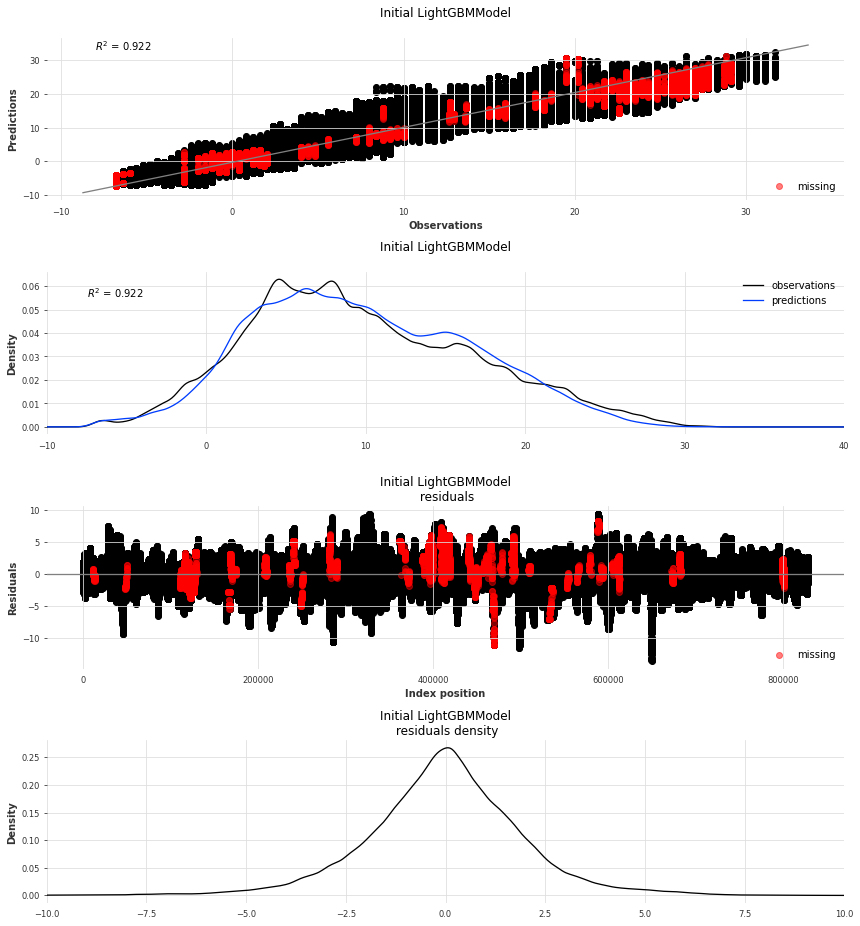

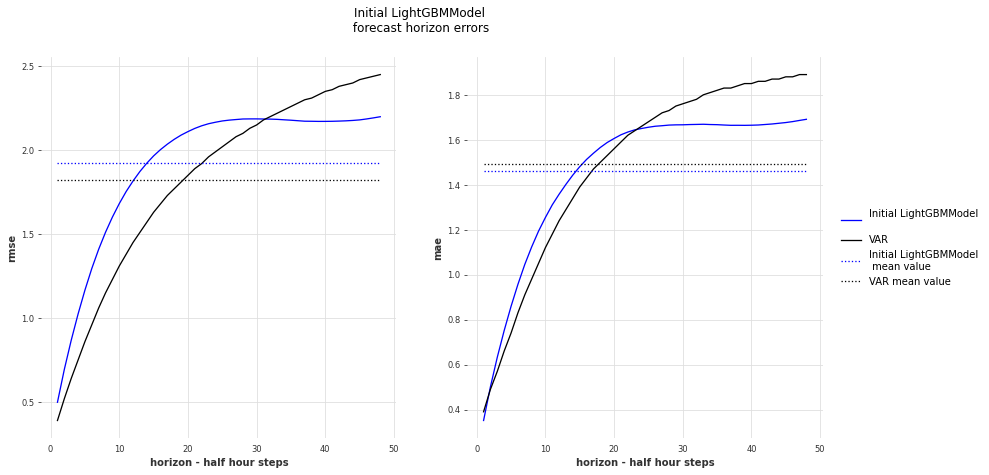

In [41]:
title = 'Initial LightGBMModel\n'

plot_obs_vs_preds(hist_comp, title)
plot_obs_preds_dists(hist_comp, title)
plot_residuals(hist_comp, title + ' residuals')
plot_residuals_dist(hist_comp, title + ' residuals density')
plot_horizon_metrics(hist_comp, title)
# plot_forecast_examples(hist_comp, title + ' forecast examples')


The diagnostic plots indicate this is a reasonable first model.
The forecast horizon plot shows the superiority of the vector autoregressive (VAR) model, but the lightgbm model is already better than most of the deep learning models.  The forecast examples (final) plot show 3 cases with high positive rmse values and 3 cases with low negative rmse values.  These are clear under- and over-estimates, but the form of these forecasts shows some similarities to the observations. 

---

Plot feature importance:

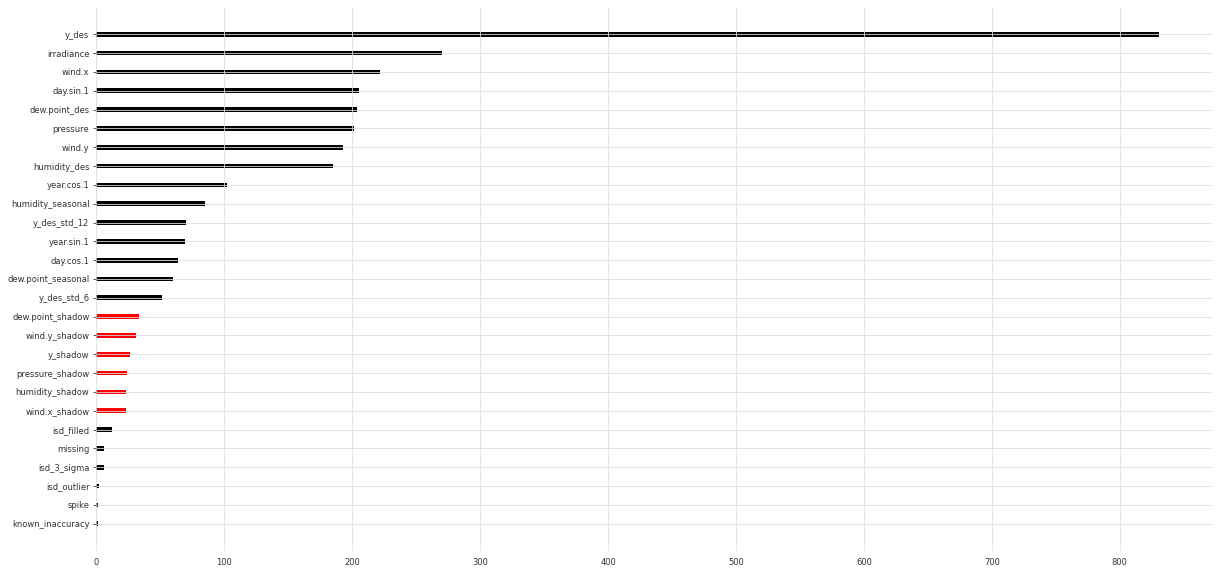

In [52]:
plot_importances(model, train_df, exclude_cols = ex_cols)  #, include_cols=include_cols)

In [30]:
inc_cols = get_most_important_variables(model, train_df, 56, exclude_cols = ex_cols)
display(train_df.loc[:, inc_cols['feature']].describe())

inc_cols:
               feature  importance
2            day.cos.1          56
5   dew.point_seasonal          72
30          year.sin.1          77
9    humidity_seasonal          83
29          year.cos.1         117
8         humidity_des         196
21            pressure         200
3            day.sin.1         208
26              wind.y         213
4        dew.point_des         213
24              wind.x         236
11          irradiance         266
0                y_des         858


,day.cos.1,dew.point_seasonal,year.sin.1,humidity_seasonal,year.cos.1,humidity_des,pressure,day.sin.1,wind.y,dew.point_des,wind.x,irradiance,y_des
count,2.028060e+05,202806.000000,202806.000000,202806.000000,202806.000000,202806.000000,202806.000000,2.028060e+05,2.028060e+05,202806.000000,2.028060e+05,202806.000000,202806.000000
mean,-5.653417e-03,5.955010,-0.008352,77.959445,-0.014448,0.388885,1014.720012,-3.546463e-03,-1.259132e+00,0.190388,-1.683985e+00,144.955304,0.016402
std,7.067750e-01,3.779633,0.713967,12.855713,0.699984,11.694161,11.804488,7.074104e-01,3.720403e+00,3.397701,4.060681e+00,227.442864,3.313267
min,-1.000000e+00,-1.735714,-1.000000,40.571429,-1.000000,-54.533333,963.000000,-1.000000e+00,-2.450000e+01,-19.878333,-2.880000e+01,0.000000,-12.923810
25%,-7.071068e-01,2.478571,-0.725233,68.214286,-0.705957,-7.059643,1008.000000,-7.071068e-01,-3.252691e+00,-2.096741,-3.800000e+00,0.000000,-2.228571
50%,-1.844552e-12,5.864621,-0.021219,82.415804,-0.030964,0.428571,1016.000000,-1.061848e-12,0.000000e+00,0.221429,-2.000000e-01,0.003180,-0.064286
75%,7.071068e-01,9.387755,0.719752,88.357143,0.675998,7.785714,1023.000000,7.071068e-01,1.983928e-15,2.578571,1.898203e-16,225.341118,2.257143
max,1.000000e+00,13.728571,1.000000,97.264286,1.000000,50.533333,1051.000000,1.000000e+00,2.180000e+01,12.407143,1.477853e+01,805.382014,13.578571


The 6 shadow variables are clustered together on the importance plots.
In this case it was not beneficial to remove any of the features above the shadow variables.

The selected features include:
 * `day.cos.1`          
 * `year.cos.1`         
 * `year.sin.1`         
 * `dew.point`         
 * `pressure`         
 * `wind.y`         
 * `humidity`         
 * `wind.x`         
 * `day.sin.1`         
 * `irradiance`         
 * `y_des`  

---

#### Lag selection - first round

Initial round of lag selection for both target and past covariates.

I did some brief experiments with future covariates but they did not prove beneficial with lightgbm and this data set.  This is a little surprising because it proved useful with the VAR baseline.

There are two approaches to specifying lags in the darts package:
 1. single integer eg. 6
   * which includes -1, -2, -3, -4, -5, -6

 2. list of integers eg. -1, -2, -3, -23, -24, -25


But first, use statsmodels package to plot autocorrelation function (ACF) and partial autocorrelation function (PACF).  Perhaps this will give some insight into which lag values to choose.

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


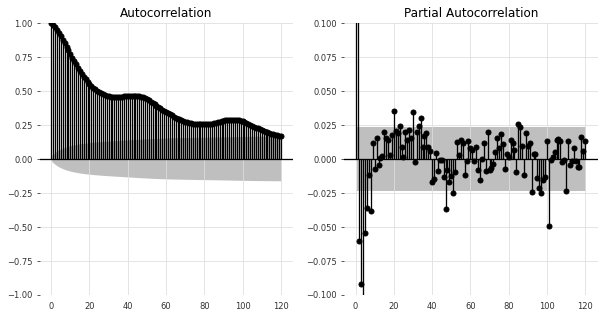

In [ ]:
import statsmodels.api as sm


n = 7000
max_lag = 120

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sm.graphics.tsa.plot_acf(df[Y_COL].head(n), missing='drop',  lags=max_lag, ax=ax[0])
sm.graphics.tsa.plot_pacf(df[Y_COL].dropna().head(n), lags=max_lag, ax=ax[1])
ax[1].set_ylim((-0.1, 0.1))
plt.show()

,pac
0,1.000000
1,0.985209
2,-0.060189
3,-0.092322
4,-0.104659
5,-0.054750
6,-0.036157
8,-0.038496
20,0.035105
30,0.034734


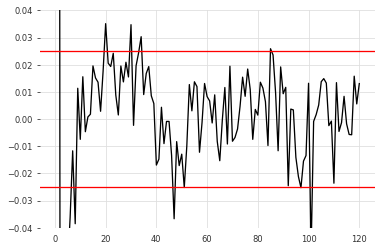

In [ ]:
from statsmodels.tsa.stattools import acf, pacf


# ac  = acf(df[Y_COL].head(n), missing='drop', nlags=max_lag)
# plt.plot(ac);

pac = pacf(df[Y_COL].dropna().head(n), nlags=max_lag)
plt.plot(pac)
plt.axhline(y= 0.025, color='r', linestyle='-')
plt.axhline(y=-0.025, color='r', linestyle='-')
ax = plt.gca()
ax.set_ylim([-0.04, 0.04]);

pac_df = pd.DataFrame(pac, columns=['pac'])
pac_df.loc[abs(pac_df['pac']) > 0.026, :]

The ACF shows significance up to around 120 lags.

The PACF show high significance up to 6 and sporadic lower significance after that.  

---

For the first round of lag selection, start with the single integer approach for both the target and past covariates.

Specifically:

   * target_lags -   [1, 3, 6, 12, 24, 48]
   * past_cov_lags - [1, 3, 6, 12, 24, 48]

This gives a total of 36 combinations of lags.

The models below are built on the full training data but evaluated on two data sets:
 1. valid_df - standard validation data
 2. 2016 data from the training data set
    * this was intended to give a quick indication of the training error
    * the `historical_forecasts` function call in the `calculate_rmse_mae_from_backtest` function is quite time consuming on the full training data
    * the training metrics are not as important as the validation metrics

In [ ]:
param_grid = {
   'target_lags':   [1, 3, 6, 12, 24, 48],
   'past_cov_lags': [1, 3, 6, 12, 24, 48],
}

param_df = expand_grid(param_grid)
param_df['target_lags']   = param_df['target_lags'].astype('int64')
param_df['past_cov_lags'] = param_df['past_cov_lags'].astype('int64')
param_df['val_rmse']   = param_df['val_mae']   = 10.0
param_df['train_rmse'] = param_df['train_mae'] = 10.0


series = TimeSeries.from_dataframe(train_df, value_cols=Y_COL)
past_cov = TimeSeries.from_dataframe(train_df.loc[:, inc_cols['feature']])

val_ser = TimeSeries.from_dataframe(valid_df, value_cols=Y_COL)
val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, inc_cols['feature']])

df['year'] = df['ds'].dt.year
train_2016 = df.loc[df['year'] == 2016]
train_2016 = train_2016.asfreq(freq='30min')

train_2016 = train_2016.drop(['year'], axis = 1)
df = df.drop(['year'], axis = 1)

train_ser = TimeSeries.from_dataframe(train_2016, value_cols=Y_COL)
train_past_cov = TimeSeries.from_dataframe(train_2016.loc[:, inc_cols['feature']])


for i in param_df.index:
    print("\ni:", i)
    target_lags, past_cov_lags = param_df.loc[i, ['target_lags', 'past_cov_lags']]

    model = LightGBMModel(lags = int(target_lags),
                          lags_past_covariates = int(past_cov_lags))
    model.fit(series, past_covariates = past_cov)

    param_df = calculate_rmse_mae_from_backtest(model, param_df, i, val_ser,   val_past_cov,   valid_df,   'val')
    param_df = calculate_rmse_mae_from_backtest(model, param_df, i, train_ser, train_past_cov, train_2016, 'train')
    display(param_df.loc[i, :])


display(param_df.sort_values('val_rmse'))

i: 0


100%|██████████| 17247/17247 [04:37<00:00, 62.10it/s]


target_lags      1.000000
past_cov_lags    1.000000
val_rmse         2.523787
val_mae          1.964767
train_rmse       2.271316
train_mae        1.779163
Name: 0, dtype: float64

i: 1


100%|██████████| 17247/17247 [04:41<00:00, 61.34it/s]


target_lags      1.000000
past_cov_lags    3.000000
val_rmse         2.864480
val_mae          2.223651
train_rmse       2.658081
train_mae        2.038453
Name: 1, dtype: float64

i: 2


100%|██████████| 17247/17247 [04:41<00:00, 61.24it/s]


target_lags      1.000000
past_cov_lags    6.000000
val_rmse         3.161309
val_mae          2.457353
train_rmse       3.103291
train_mae        2.347906
Name: 2, dtype: float64

i: 3


100%|██████████| 17247/17247 [04:42<00:00, 61.12it/s]


target_lags       1.000000
past_cov_lags    12.000000
val_rmse          3.366454
val_mae           2.605434
train_rmse        3.326870
train_mae         2.506328
Name: 3, dtype: float64

i: 4


100%|██████████| 17247/17247 [04:50<00:00, 59.38it/s]


target_lags       1.000000
past_cov_lags    24.000000
val_rmse          3.030240
val_mae           2.352440
train_rmse        2.877419
train_mae         2.196992
Name: 4, dtype: float64

i: 5


100%|██████████| 17247/17247 [04:58<00:00, 57.87it/s]


target_lags       1.000000
past_cov_lags    48.000000
val_rmse          2.822639
val_mae           2.208754
train_rmse        2.646217
train_mae         2.033703
Name: 5, dtype: float64

i: 6


100%|██████████| 17247/17247 [04:55<00:00, 58.40it/s]


target_lags      3.000000
past_cov_lags    1.000000
val_rmse         2.549150
val_mae          1.985528
train_rmse       2.271016
train_mae        1.780764
Name: 6, dtype: float64

i: 7


100%|██████████| 17247/17247 [04:49<00:00, 59.48it/s]


target_lags      3.000000
past_cov_lags    3.000000
val_rmse         2.580594
val_mae          2.010235
train_rmse       2.320968
train_mae        1.819077
Name: 7, dtype: float64

i: 8


100%|██████████| 17247/17247 [04:52<00:00, 58.94it/s]


target_lags      3.000000
past_cov_lags    6.000000
val_rmse         4.308065
val_mae          3.430289
train_rmse       4.486168
train_mae        3.539996
Name: 8, dtype: float64

i: 9


100%|██████████| 17247/17247 [04:55<00:00, 58.43it/s]


target_lags       3.000000
past_cov_lags    12.000000
val_rmse          4.340830
val_mae           3.480154
train_rmse        4.479570
train_mae         3.552341
Name: 9, dtype: float64

i: 10


100%|██████████| 17247/17247 [04:59<00:00, 57.50it/s]


target_lags       3.000000
past_cov_lags    24.000000
val_rmse          3.925677
val_mae           3.143612
train_rmse        3.921444
train_mae         3.128535
Name: 10, dtype: float64

i: 11


100%|██████████| 17247/17247 [05:07<00:00, 56.08it/s]


target_lags       3.000000
past_cov_lags    48.000000
val_rmse          3.487449
val_mae           2.791718
train_rmse        3.349577
train_mae         2.664869
Name: 11, dtype: float64

i: 12


100%|██████████| 17247/17247 [04:58<00:00, 57.75it/s]


target_lags      6.000000
past_cov_lags    1.000000
val_rmse         2.547121
val_mae          1.981322
train_rmse       2.294768
train_mae        1.806548
Name: 12, dtype: float64

i: 13


100%|██████████| 17247/17247 [05:12<00:00, 55.22it/s]


target_lags      6.000000
past_cov_lags    3.000000
val_rmse         2.629843
val_mae          2.041249
train_rmse       2.346820
train_mae        1.840945
Name: 13, dtype: float64

i: 14


100%|██████████| 17247/17247 [05:12<00:00, 55.19it/s]


target_lags      6.000000
past_cov_lags    6.000000
val_rmse         2.677021
val_mae          2.082416
train_rmse       2.403444
train_mae        1.881377
Name: 14, dtype: float64

i: 15


100%|██████████| 17247/17247 [05:07<00:00, 56.17it/s]


target_lags       6.000000
past_cov_lags    12.000000
val_rmse          3.008009
val_mae           2.362991
train_rmse        2.715740
train_mae         2.142602
Name: 15, dtype: float64

i: 16


100%|██████████| 17247/17247 [05:15<00:00, 54.70it/s]


target_lags       6.000000
past_cov_lags    24.000000
val_rmse          2.862774
val_mae           2.245376
train_rmse        2.572677
train_mae         2.024488
Name: 16, dtype: float64

i: 17


100%|██████████| 17247/17247 [05:11<00:00, 55.29it/s]


target_lags       6.000000
past_cov_lags    48.000000
val_rmse          2.831088
val_mae           2.226011
train_rmse        2.537688
train_mae         1.987293
Name: 17, dtype: float64

i: 18


100%|██████████| 17247/17247 [05:05<00:00, 56.44it/s]


target_lags      12.000000
past_cov_lags     1.000000
val_rmse          2.578362
val_mae           2.009075
train_rmse        2.291462
train_mae         1.797028
Name: 18, dtype: float64

i: 19


100%|██████████| 17247/17247 [05:09<00:00, 55.77it/s]


target_lags      12.000000
past_cov_lags     3.000000
val_rmse          2.644889
val_mae           2.052505
train_rmse        2.353849
train_mae         1.837688
Name: 19, dtype: float64

i: 20


100%|██████████| 17247/17247 [05:12<00:00, 55.20it/s]


target_lags      12.000000
past_cov_lags     6.000000
val_rmse          2.694629
val_mae           2.096843
train_rmse        2.398370
train_mae         1.875997
Name: 20, dtype: float64

i: 21


100%|██████████| 17247/17247 [05:07<00:00, 56.04it/s]


target_lags      12.000000
past_cov_lags    12.000000
val_rmse          2.722214
val_mae           2.112044
train_rmse        2.417448
train_mae         1.892010
Name: 21, dtype: float64

i: 22


100%|██████████| 17247/17247 [05:15<00:00, 54.59it/s]


target_lags      12.000000
past_cov_lags    24.000000
val_rmse          2.537214
val_mae           1.969093
train_rmse        2.269917
train_mae         1.782932
Name: 22, dtype: float64

i: 23


100%|██████████| 17247/17247 [05:20<00:00, 53.79it/s]


target_lags      12.000000
past_cov_lags    48.000000
val_rmse          2.470012
val_mae           1.938361
train_rmse        2.213138
train_mae         1.739543
Name: 23, dtype: float64

i: 24


100%|██████████| 17247/17247 [05:13<00:00, 55.00it/s]


target_lags      24.000000
past_cov_lags     1.000000
val_rmse          2.527399
val_mae           1.968962
train_rmse        2.255743
train_mae         1.770281
Name: 24, dtype: float64

i: 25


100%|██████████| 17247/17247 [05:03<00:00, 56.86it/s]


target_lags      24.000000
past_cov_lags     3.000000
val_rmse          2.570024
val_mae           1.995347
train_rmse        2.270586
train_mae         1.778648
Name: 25, dtype: float64

i: 26


100%|██████████| 17247/17247 [05:05<00:00, 56.48it/s]


target_lags      24.000000
past_cov_lags     6.000000
val_rmse          2.593723
val_mae           2.013392
train_rmse        2.298448
train_mae         1.806560
Name: 26, dtype: float64

i: 27


100%|██████████| 17247/17247 [05:05<00:00, 56.46it/s]


target_lags      24.000000
past_cov_lags    12.000000
val_rmse          2.636298
val_mae           2.037589
train_rmse        2.323017
train_mae         1.826459
Name: 27, dtype: float64

i: 28


100%|██████████| 17247/17247 [05:13<00:00, 55.02it/s]


target_lags      24.000000
past_cov_lags    24.000000
val_rmse          2.633480
val_mae           2.045036
train_rmse        2.348930
train_mae         1.846763
Name: 28, dtype: float64

i: 29


100%|██████████| 17247/17247 [05:11<00:00, 55.35it/s]


target_lags      24.000000
past_cov_lags    48.000000
val_rmse          2.469198
val_mae           1.939151
train_rmse        2.211941
train_mae         1.737770
Name: 29, dtype: float64

i: 30


100%|██████████| 17247/17247 [05:05<00:00, 56.53it/s]


target_lags      48.000000
past_cov_lags     1.000000
val_rmse          2.511462
val_mae           1.962423
train_rmse        2.200603
train_mae         1.732773
Name: 30, dtype: float64

i: 31


100%|██████████| 17247/17247 [05:04<00:00, 56.58it/s]


target_lags      48.000000
past_cov_lags     3.000000
val_rmse          2.531510
val_mae           1.975859
train_rmse        2.200381
train_mae         1.727330
Name: 31, dtype: float64

i: 32


100%|██████████| 17247/17247 [05:07<00:00, 56.13it/s]


target_lags      48.000000
past_cov_lags     6.000000
val_rmse          2.590250
val_mae           2.010722
train_rmse        2.252448
train_mae         1.772794
Name: 32, dtype: float64

i: 33


100%|██████████| 17247/17247 [05:08<00:00, 55.95it/s]


target_lags      48.000000
past_cov_lags    12.000000
val_rmse          2.590436
val_mae           2.015162
train_rmse        2.279025
train_mae         1.794869
Name: 33, dtype: float64

i: 34


100%|██████████| 17247/17247 [05:12<00:00, 55.25it/s]


target_lags      48.000000
past_cov_lags    24.000000
val_rmse          2.586987
val_mae           2.017223
train_rmse        2.289324
train_mae         1.803867
Name: 34, dtype: float64

i: 35


100%|██████████| 17247/17247 [05:15<00:00, 54.68it/s]


target_lags      48.000000
past_cov_lags    48.000000
val_rmse          2.518143
val_mae           1.977319
train_rmse        2.251446
train_mae         1.768704
Name: 35, dtype: float64

KeyError: ignored

,past_cov_lags,val_rmse,val_mae,train_rmse,train_mae,target_lags
target_lags,,,,,,
24,48,2.469198,1.939151,2.211941,1.737770,24
12,48,2.470012,1.938361,2.213138,1.739543,12
48,1,2.511462,1.962423,2.200603,1.732773,48
48,48,2.518143,1.977319,2.251446,1.768704,48
1,1,2.523787,1.964767,2.271316,1.779163,1
24,1,2.527399,1.968962,2.255743,1.770281,24
48,3,2.531510,1.975859,2.200381,1.727330,48
12,24,2.537214,1.969093,2.269917,1.782932,12
6,1,2.547121,1.981322,2.294768,1.806548,6


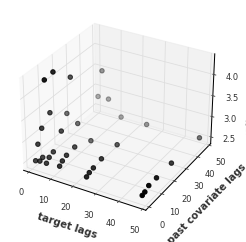

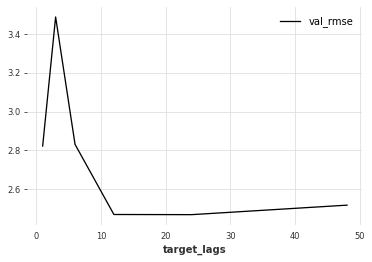

In [ ]:
display(param_df.sort_values('val_rmse'))


ax = plt.figure().add_subplot(projection='3d')
ax.scatter(param_df['target_lags'], param_df['past_cov_lags'], param_df['val_rmse'])
ax.set_xlabel('target lags')
ax.set_ylabel('past covariate lags')
ax.set_zlabel('validation rmse')


param_df.loc[param_df['past_cov_lags'] == 48, ['target_lags','val_rmse']].plot(x='target_lags', y='val_rmse');


There are 4 combinations of target lags and past covariate lags which improve on the initial `lags = 1` and `past_cov_lags = 1`.  The top 2 combinations have largely indistinguishable rmse and mae values.  The `lags = 12` and `past_cov_lags = 48` is preferable because it uses fewer lags than the alternative `lags = 24` and `past_cov_lags = 48`.

The final plot above shows the validation rmse for `past_cov_lags == 48`.

This table summarises the small improvement gained by adding lagged features.

| target_lag | past_cov_lag | 48th valid rmse | 48th valid mae |
|------------|--------------|-----------------|----------------|
| 24	       | 48	          | 2.469198	      | 1.939151	     |
| 12	       | 48	          |	2.470012	      | 1.938361	     |
| 1	         | 1	          |	2.523787	      | 1.964767	     |


---

#### Lag selection - second round

Second round of lag selection for target and past covariates.

This time, specifying `past_cov_lags = 48` and increasing the target `lag` value from 1 to 48, including all earlier lags, but with an early stopping limit.  If the validation rmse value is greater than the previous value then the early stopping value is increased.  If the early stopping value reaches 5 then lag selection is terminated.



In [ ]:
es = 0  # early stopping
es_lim = 5

param_grid = {
   'target_lags': [i for i in range(1, HORIZON+1)],
}
param_df = expand_grid(param_grid)
param_df['target_lags']   = param_df['target_lags'].astype('int64')
param_df['past_cov_lags'] = 48
param_df['val_rmse']   = param_df['val_mae']   = 10.0
param_df['train_rmse'] = param_df['train_mae'] = 10.0

series = TimeSeries.from_dataframe(train_df, value_cols=Y_COL)
past_cov = TimeSeries.from_dataframe(train_df.loc[:, inc_cols['feature']])

val_ser = TimeSeries.from_dataframe(valid_df, value_cols=Y_COL)
val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, inc_cols['feature']])

df['year'] = df['ds'].dt.year
train_2016 = df.loc[df['year'] == 2016]
train_2016 = train_2016.asfreq(freq='30min')

train_2016 = train_2016.drop(['year'], axis = 1)
df = df.drop(['year'], axis = 1)

train_ser = TimeSeries.from_dataframe(train_2016, value_cols=Y_COL)
train_past_cov = TimeSeries.from_dataframe(train_2016.loc[:, inc_cols['feature']])


for i in range(param_df.shape[0]):
    target_lags = np.negative(param_df.loc[0:i, 'target_lags']).to_list()
    print("\ni:", i, "es:", es, "lags:", target_lags)

    model = LightGBMModel(lags = target_lags,
                          lags_past_covariates = int(param_df.loc[i, 'past_cov_lags']))
    model.fit(series, past_covariates = past_cov)

    param_df = calculate_rmse_mae_from_backtest(model, param_df, i, val_ser,   val_past_cov,   valid_df,   'val')
    param_df = calculate_rmse_mae_from_backtest(model, param_df, i, train_ser, train_past_cov, train_2016, 'train')
    display(param_df.loc[i, :])

    if i > 12 and param_df.loc[i, 'val_rmse'] > param_df.loc[i-1, 'val_rmse']:
        es += 1
        if es == es_lim:
            break
    else:
        es = 0


display(param_df.loc[param_df['val_rmse'] < 10.0, :].sort_values('val_rmse'))


 0 [-1]


100%|██████████| 17247/17247 [05:16<00:00, 54.56it/s]


target_lags       1.000000
past_cov_lags    48.000000
val_rmse          2.822639
val_mae           2.208754
train_rmse        2.646217
train_mae         2.033703
Name: 0, dtype: float64


 1 [-1, -2]


100%|██████████| 17247/17247 [05:16<00:00, 54.49it/s]


target_lags       2.000000
past_cov_lags    48.000000
val_rmse          3.298214
val_mae           2.637320
train_rmse        3.166304
train_mae         2.500817
Name: 1, dtype: float64


 2 [-1, -2, -3]


100%|██████████| 17247/17247 [05:20<00:00, 53.87it/s]


target_lags       3.000000
past_cov_lags    48.000000
val_rmse          3.487449
val_mae           2.791718
train_rmse        3.349577
train_mae         2.664869
Name: 2, dtype: float64


 3 [-1, -2, -3, -4]


100%|██████████| 17247/17247 [05:26<00:00, 52.82it/s]


target_lags       4.000000
past_cov_lags    48.000000
val_rmse          3.406558
val_mae           2.729689
train_rmse        3.214634
train_mae         2.551085
Name: 3, dtype: float64


 4 [-1, -2, -3, -4, -5]


100%|██████████| 17247/17247 [05:14<00:00, 54.89it/s]


target_lags       5.000000
past_cov_lags    48.000000
val_rmse          3.095124
val_mae           2.462717
train_rmse        2.832016
train_mae         2.232566
Name: 4, dtype: float64


 5 [-1, -2, -3, -4, -5, -6]


100%|██████████| 17247/17247 [05:12<00:00, 55.14it/s]


target_lags       6.000000
past_cov_lags    48.000000
val_rmse          2.831088
val_mae           2.226011
train_rmse        2.537688
train_mae         1.987293
Name: 5, dtype: float64


 6 [-1, -2, -3, -4, -5, -6, -7]


100%|██████████| 17247/17247 [05:12<00:00, 55.27it/s]


target_lags       7.000000
past_cov_lags    48.000000
val_rmse          2.675662
val_mae           2.105008
train_rmse        2.401247
train_mae         1.885076
Name: 6, dtype: float64


 7 [-1, -2, -3, -4, -5, -6, -7, -8]


100%|██████████| 17247/17247 [05:15<00:00, 54.68it/s]


target_lags       8.000000
past_cov_lags    48.000000
val_rmse          2.579754
val_mae           2.025168
train_rmse        2.313387
train_mae         1.815444
Name: 7, dtype: float64


 8 [-1, -2, -3, -4, -5, -6, -7, -8, -9]


100%|██████████| 17247/17247 [05:13<00:00, 54.94it/s]


target_lags       9.000000
past_cov_lags    48.000000
val_rmse          2.501043
val_mae           1.962445
train_rmse        2.243237
train_mae         1.760600
Name: 8, dtype: float64


 9 [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10]


100%|██████████| 17247/17247 [05:14<00:00, 54.86it/s]


target_lags      10.000000
past_cov_lags    48.000000
val_rmse          2.477252
val_mae           1.944483
train_rmse        2.221007
train_mae         1.743275
Name: 9, dtype: float64


 10 [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11]


100%|██████████| 17247/17247 [05:09<00:00, 55.78it/s]


target_lags      11.000000
past_cov_lags    48.000000
val_rmse          2.477679
val_mae           1.945703
train_rmse        2.219236
train_mae         1.742837
Name: 10, dtype: float64


 11 [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12]


100%|██████████| 17247/17247 [05:08<00:00, 55.82it/s]


target_lags      12.000000
past_cov_lags    48.000000
val_rmse          2.470012
val_mae           1.938361
train_rmse        2.213138
train_mae         1.739543
Name: 11, dtype: float64


 12 [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13]


100%|██████████| 17247/17247 [05:18<00:00, 54.20it/s]


target_lags      13.000000
past_cov_lags    48.000000
val_rmse          2.467105
val_mae           1.936606
train_rmse        2.210006
train_mae         1.737123
Name: 12, dtype: float64


 13 [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14]


100%|██████████| 17247/17247 [05:11<00:00, 55.37it/s]


target_lags      14.000000
past_cov_lags    48.000000
val_rmse          2.464505
val_mae           1.935875
train_rmse        2.209289
train_mae         1.736713
Name: 13, dtype: float64


 14 [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15]


100%|██████████| 17247/17247 [05:07<00:00, 56.07it/s]


target_lags      15.000000
past_cov_lags    48.000000
val_rmse          2.464645
val_mae           1.936001
train_rmse        2.209579
train_mae         1.736877
Name: 14, dtype: float64


 15 [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16]


100%|██████████| 17247/17247 [05:05<00:00, 56.55it/s]


target_lags      16.000000
past_cov_lags    48.000000
val_rmse          2.464344
val_mae           1.935860
train_rmse        2.209579
train_mae         1.736877
Name: 15, dtype: float64


 16 [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17]


100%|██████████| 17247/17247 [05:05<00:00, 56.47it/s]


target_lags      17.000000
past_cov_lags    48.000000
val_rmse          2.464344
val_mae           1.935860
train_rmse        2.209579
train_mae         1.736877
Name: 16, dtype: float64


 17 [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18]


100%|██████████| 17247/17247 [05:02<00:00, 56.96it/s]


target_lags      18.000000
past_cov_lags    48.000000
val_rmse          2.464600
val_mae           1.936152
train_rmse        2.209710
train_mae         1.736941
Name: 17, dtype: float64

,target_lags,past_cov_lags,val_rmse,val_mae,train_rmse,train_mae
15,16,48,2.464344,1.935860,2.209579,1.736877
16,17,48,2.464344,1.935860,2.209579,1.736877
13,14,48,2.464505,1.935875,2.209289,1.736713
17,18,48,2.464600,1.936152,2.209710,1.736941
14,15,48,2.464645,1.936001,2.209579,1.736877
12,13,48,2.467105,1.936606,2.210006,1.737123
11,12,48,2.470012,1.938361,2.213138,1.739543
9,10,48,2.477252,1.944483,2.221007,1.743275
10,11,48,2.477679,1.945703,2.219236,1.742837
8,9,48,2.501043,1.962445,2.243237,1.760600



The validation rmse decreases for `lag` values from 1 to 10 then shows little further change.

The following table indicates no significant change.

| target_lag | past_cov_lag | valid rmse | valid mae |
|------------|--------------|------------|-----------|
| 16	       | 48	          | 2.464344	 | 1.935860	 |
| 12	       | 48	          |	2.470012	 | 1.938361	 |
| 1	         | 1	          |	2.523787	 | 1.964767	 |

**TODO** Add a plot showing how validation rmse changes as the `lag` value increases.

---

#### Lag selection - third round

Third and final round of lag selection for target and past covariates.

This time, specifying target `lags = 12` and eliminating `past_cov_lag` values starting at 48 and decreasing to 1, excluding all later lags.  Again, using an early stopping limit.  If the validation rmse value is greater than the previous value then the early stopping value is increased.  If the early stopping value reaches 5 then lag selection is terminated.


...

The following table indicates ...

| target_lag | past_cov_lag | 48th valid rmse | 48th valid mae |
|------------|--------------|-----------------|----------------|
| 12	       | ...          |	...     	      | ...    	       |
| 16	       | 48	          | 2.464344	      | 1.935860	     |
| 12	       | 48	          |	2.470012	      | 1.938361	     |
| 1	         | 1	          |	2.523787	      | 1.964767	     |

It may be possible to further improve lag selection by adding specific lags around the 12 hour and 24 hour marks and/or removing specific lags around the 6 hour and 18 hour marks.

---

### 2. darts catboost


It is unrealistic to concurrently optimise all of the time series gradient boosting components on google colab.  So, an iterative process is necessary.

I use the same features that were selected for the lightgbm models.
They include:
 * `day.cos.1`          
 * `year.cos.1`         
 * `year.sin.1`         
 * `dew.point`         
 * `pressure`         
 * `wind.y`         
 * `humidity`         
 * `wind.x`         
 * `day.sin.1`         
 * `irradiance`         
 * `y_des`  

There are 2 major components to optimise:
 * lag selection
   * target series lags
   * past covariate (feature) lags
 * hyperparameter tuning
```
param_grid = {
 'n_estimators':  [100, 500],
 'max_depth':     [3, 5, 10],
 'learning_rate': [0.01, 0.1]
 }
```

Before starting lag selection, build an initial `lags = 1` and `lags_past_covariates = 1` catboost model:

In [ ]:
series = TimeSeries.from_dataframe(train_df, value_cols=Y_COL)
past_cov = TimeSeries.from_dataframe(train_df.loc[:, inc_cols['feature']])

val_ser = TimeSeries.from_dataframe(valid_df, value_cols=Y_COL)
val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, inc_cols['feature']])

print("valid_df['", Y_COL, "']:\n", valid_df[Y_COL].describe(), "\n", sep='')


model2 = CatBoostModel(lags = 1,
                       lags_past_covariates = 1)

model2.fit(series, 
           past_covariates = past_cov,
           val_series = val_ser,
           val_past_covariates = val_past_cov)
backtest2 = model2.historical_forecasts(series = val_ser, 
                                       past_covariates = val_past_cov,
                                       start   = 0.01, 
                                       retrain = False,
                                       verbose = True, 
                                       forecast_horizon = HORIZON,
                                       last_points_only = False)

hist_comp2 = calculate_historic_comparison(backtest2, valid_df)
summarise_hist_comp(hist_comp2, valid_df)
title2 = 'Initial CatBoostModel\n'
plot_learning_curve(model2, title2)
plot_learning_curve(model2, title2, margin=0.05)


# CatBoost
# missing == 0.0 only
#        feature  importance
# 5    dew.point          42
# 3    day.cos.1          66
# 1           ah          97
# 29  year.cos.1         111
# 30  year.sin.1         119
# 26      wind.y         221
# 21    pressure         226
# 4    day.sin.1         230
# 24      wind.x         231
# 8     humidity         254
# 10  irradiance         296
# 0        y_des         910
# Backtest RMSE: 0.628032
# Backtest MAE:  0.460348

# CatBoost
# df['mi_filled'] != 1.0 & df['hist_average'] != 1.0
#        feature  importance
# 3    day.cos.1          59
# 5    dew.point          65
# 1           ah          84
# 30  year.sin.1         114
# 29  year.cos.1         120
# 21    pressure         217
# 26      wind.y         218
# 4    day.sin.1         231
# 24      wind.x         242
# 8     humidity         255
# 10  irradiance         276
# 0        y_des         880
# Backtest RMSE: 0.641121
# Backtest MAE:  0.471475
# not as good as missing == 0.0 only :-(
    
# CatBoost
# df['mi_filled'] != 1.0 & df['hist_average'] != 1.0 and 
# no train_df.asfreq('30mins', method='ffill')
#        feature  importance
# 3    day.cos.1          63
# 5    dew.point          67
# 1           ah          75
# 29  year.cos.1         114
# 30  year.sin.1         121
# 21    pressure         206
# 24      wind.x         231
# 4    day.sin.1         232
# 26      wind.y         236
# 8     humidity         256
# 10  irradiance         288
# 0        y_des         873
# Backtest RMSE: 0.654792
# Backtest MAE:  0.480289

# CatBoost
# df['mi_filled'] != 1.0 & df['hist_average'] != 1.0 and
# no train_df.asfreq('30mins', method='ffill') and
# no ah or mixing_ratio
#        feature  importance
# 2    day.cos.1          72
# 28  year.sin.1         102
# 27  year.cos.1         117
# 4    dew.point         143
# 19    pressure         219
# 24      wind.y         231
# 3    day.sin.1         232
# 22      wind.x         247
# 7     humidity         253
# 9   irradiance         299
# 0        y_des         880
# Backtest RMSE: 0.568025
# Backtest MAE:  0.412278
# New baseline :-)

# CatBoost
# with irradiance
#        feature  importance
# 30  year.sin.1          92
# 3    day.cos.1         102
# 17   mi_filled         121
# 5    dew.point         122
# 26      wind.y         131
# 29  year.cos.1         139
# 10  irradiance         142
# 21    pressure         154
# 24      wind.x         154
# 4    day.sin.1         177
# 8     humidity         229
# 0        y_des         766
# Backtest RMSE: 0.672793
# Backtest MAE:  0.450387
# Overfitting??

# CatBoost
# with irradiance and y_des_48_cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)
# inc_cols = ['y_des', 'humidity', 'day.sin.1', 'wind.x', 'pressure', \
#             'irradiance', 'year.cos.1', 'wind.y', 'dew.point', \
#             'mi_filled', 'day.cos.1', 'year.sin.1', \
#             'y_des_48_cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)']
# Backtest RMSE: 0.710947
# Backtest MAE:  0.47479
# Worse than above :-(

# lightGBM
# with irradiance
#        feature  importance
# 30  year.sin.1          92
# 3    day.cos.1         102
# 17   mi_filled         121
# 5    dew.point         122
# 26      wind.y         131
# 29  year.cos.1         139
# 10  irradiance         142
# 21    pressure         154
# 24      wind.x         154
# 4    day.sin.1         177
# 8     humidity         229
# 0        y_des         766
# Backtest RMSE: 2.454909
# Backtest MAE:  1.917347

# lightGBM
# with irradiance and y_des_48_cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)
# inc_cols = ['y_des', 'humidity', 'day.sin.1', 'wind.x', 'pressure', \
#             'irradiance', 'year.cos.1', 'wind.y', 'dew.point', \
#             'mi_filled', 'day.cos.1', 'year.sin.1', \
#             'y_des_48_cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)']
# Backtest RMSE: 2.45328
# Backtest MAE:  1.928512
# not really worth it

# CatBoost
# with irradiance and "individual" tsfresh features 
#                                         feature  importance
# 42                                       wind.y          81
# 14                                 hist_average          81
# 32                                       wind.x          90
# 3                                     day.cos.1          92
# 5                                     dew.point          94
# 60                                   year.sin.1          98
# 59                                   year.cos.1         127
# 28                                     pressure         140
# 24                                    mi_filled         140
# 17                                   irradiance         141
# 4                                     day.sin.1         176
# 15                                     humidity         206
# 54  y_des__fft_coefficient__attr_"abs"__coeff_0         230
# 52                            y_des__abs_energy         255
# 0                                         y_des         294
# Backtest RMSE: 0.95214
# Backtest MAE:  0.498428
# Worse than the other CatBoost model

# CatBoost
# with irradiance and 48ish tsfresh features and importance >= 20
# Backtest RMSE: 0.715744
# Backtest MAE:  0.474267
# 38 mins 


# tsfresh
# Backtest RMSE: 2.584641
# Backtest MAE:  1.343045

# feature_importances_ >= 0
# Backtest RMSE: 0.9712860180698543
# Backtest MAE:  0.5159408377313741
#
# Backtest RMSE: 2.5577905523320172
# Backtest MAE:  1.3275633472184116

# feature_importances_ >= 15
# Backtest RMSE: 0.9566517297164219
# Backtest MAE:  0.5130991945354627
# Best so far

# feature_importances_ >= 15
# lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
# lags_past_covariates = [-1, -22, -23, -24, -25]
# Backtest RMSE: 0.9119256007576663
# Backtest MAE:  0.4917939994435104

# CatBoostModel - approx. 38 mins run time :-(
# feature_importances_ >= 15
# lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
# lags_past_covariates = [-1, -22, -23, -24, -25]
# Backtest RMSE: 0.5845118430367099
# Backtest MAE:  0.3710012069513114

# CatBoostModel - approx. 38 mins run time :-(
# feature_importances_ >= 0
# lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
# lags_past_covariates = [-1, -22, -23, -24, -25]
# Backtest RMSE: 0.9779049136141091
# Backtest MAE:  0.5044682465050189

valid_df['y_des']:
count    16923.000000
mean        -0.382437
std          3.540825
min        -12.371429
25%         -2.592857
50%         -0.373333
75%          1.800000
max         12.914286
Name: y_des, dtype: float64



100%|██████████| 17263/17263 [16:41<00:00, 17.24it/s]


Backtest RMSE all: 0.673271
Backtest MAE all:  0.455403

# Backtest RMSE 48th: 0.677639
# Backtest MAE 48th:  0.45948

Backtest RMSE miss==0: 0.664353
Backtest MAE miss==0:  0.452279

Backtest RMSE miss==1: 1.317232
Backtest MAE miss==1:  0.791042


backtest['y_des']:
count	 801696
mean	 -0.388381
std	 3.411018
min	 -10.088277
25%	 -2.50174
50%	 -0.430423
75%	 1.739615
max	 10.542901


valid_df['y_des']:
count    16923.000000
mean        -0.382437
std          3.540825
min        -12.371429
25%         -2.592857
50%         -0.373333
75%          1.800000
max         12.914286
Name: y_des, dtype: float64



100%|██████████| 17263/17263 [12:44<00:00, 22.58it/s]


Backtest RMSE all: 0.712753
Backtest MAE all:  0.489007

# Backtest RMSE 48th: 0.718218
# Backtest MAE 48th:  0.495263

Backtest RMSE miss==0: 0.703994
Backtest MAE miss==0:  0.486112

Backtest RMSE miss==1: 1.357
Backtest MAE miss==1:  0.800064


backtest['y_des']:
count	 801696
mean	 -0.37715
std	 3.414669
min	 -10.584528
25%	 -2.505377
50%	 -0.345754
75%	 1.689239
max	 10.8388


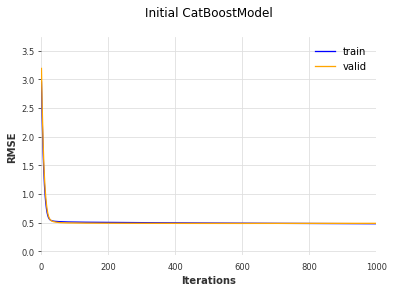

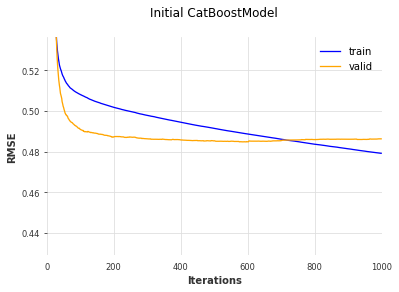

In [31]:
series = TimeSeries.from_dataframe(train_df, value_cols=Y_COL)
past_cov = TimeSeries.from_dataframe(train_df.loc[:, inc_cols['feature']])

val_ser = TimeSeries.from_dataframe(valid_df, value_cols=Y_COL)
val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, inc_cols['feature']])

print("valid_df['", Y_COL, "']:\n", valid_df[Y_COL].describe(), "\n", sep='')


model2 = CatBoostModel(lags = 1,
                       lags_past_covariates = 1)

model2.fit(series, 
           past_covariates = past_cov,
           val_series = val_ser,
           val_past_covariates = val_past_cov)
backtest2 = model2.historical_forecasts(series = val_ser, 
                                       past_covariates = val_past_cov,
                                       start   = 0.01, 
                                       retrain = False,
                                       verbose = True, 
                                       forecast_horizon = HORIZON,
                                       last_points_only = False)

hist_comp2 = calculate_historic_comparison(backtest2, valid_df)
summarise_hist_comp(hist_comp2, valid_df)
title2 = 'Initial CatBoostModel\n'
plot_learning_curve(model2, title2)
plot_learning_curve(model2, title2, margin=0.05)


# Previously
# Backtest RMSE 48th: 0.677639
# Backtest MAE 48th:  0.45948

# Deseasonal y, humidity, dew.point
# Backtest RMSE 48th: 0.718218
# Backtest MAE 48th:  0.495263
# Still overfitting but less so

This initial catboost model is clearly superior to all of the lightgbm models.
However the runtime has increased from approximately 5 mins to 13 mins.

|  model   | target_lag | past_cov_lag | 48th valid rmse | 48th valid mae |
|----------|------------|--------------|-----------------|----------------|
| catboost | 1	        | 1	           |	0.659983	     | 0.451157	      |
| lightgbm | 1	        | 1	           |	2.523787	     | 1.964767	      |

---

Plot diagnostics:

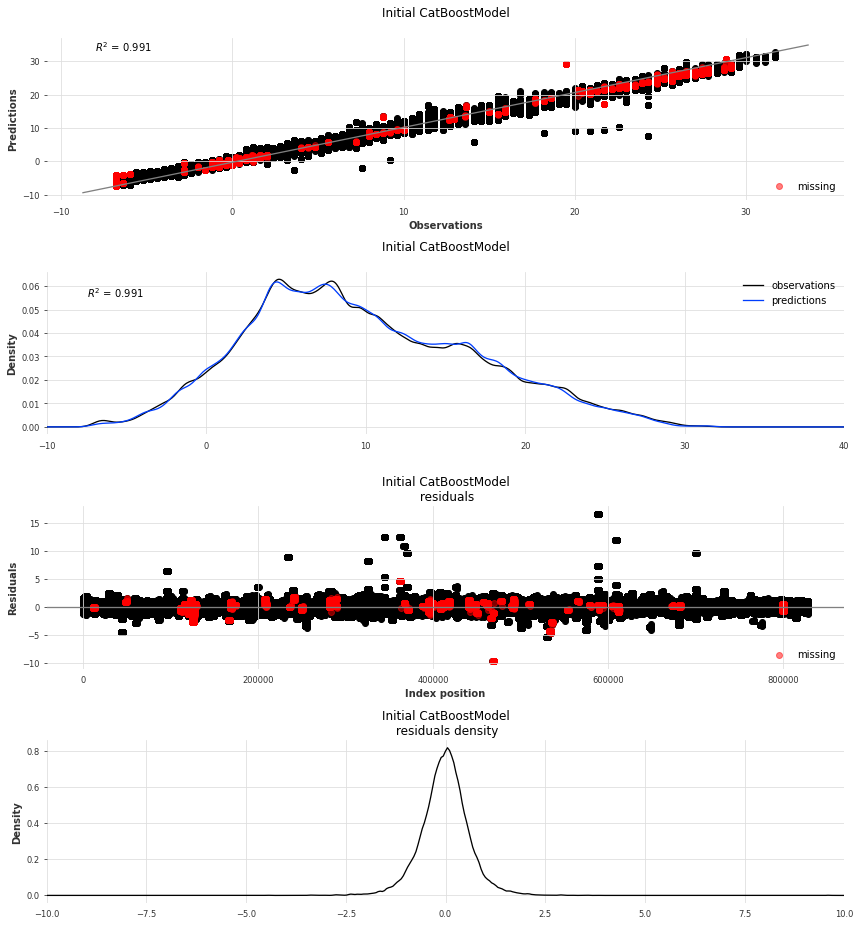

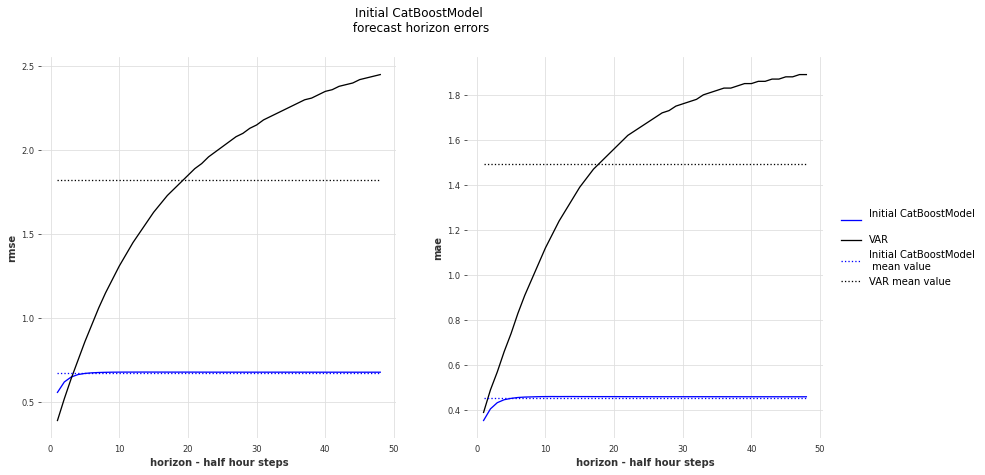

In [ ]:
plot_obs_vs_preds(hist_comp2, title2)
plot_obs_preds_dists(hist_comp2, title2)
plot_residuals(hist_comp2, title2 + ' residuals')
plot_residuals_dist(hist_comp2, title2 + ' residuals density')
plot_horizon_metrics(hist_comp2, title2)
# plot_forecast_examples(hist_comp2, title2 + ' forecast examples')

The forecast horizon plot shows the initial catboost model is clearly superior to the baseline VAR model.  However, the flatness of the catboost model and the large difference with the VAR model may indicate overfitting.

---

If overfitting is present then regularisation should help to lessen/prevent it.  The best parameter to regularise catboost models is `n_estimators` which is the number of trees built (default value 1,000).  See [catboost docs](https://catboost.ai/en/docs/references/training-parameters/common#iterations) for further details.

Here I try two extremely low values for `n_estimators`: 1 and 2.

100%|██████████| 17263/17263 [16:47<00:00, 17.13it/s]


Backtest RMSE all: 2.445129
Backtest MAE all:  1.837754

# Backtest RMSE 48th: 2.502509
# Backtest MAE 48th:  1.900066

Backtest RMSE miss==0: 2.416085
Backtest MAE miss==0:  1.818566

Backtest RMSE miss==1: 4.598916
Backtest MAE miss==1:  3.899664


backtest['y_des']:
count	 801696
mean	 -0.476854
std	 1.31215
min	 -3.447279
25%	 -1.175371
50%	 -0.373343
75%	 0.332919
max	 2.587382


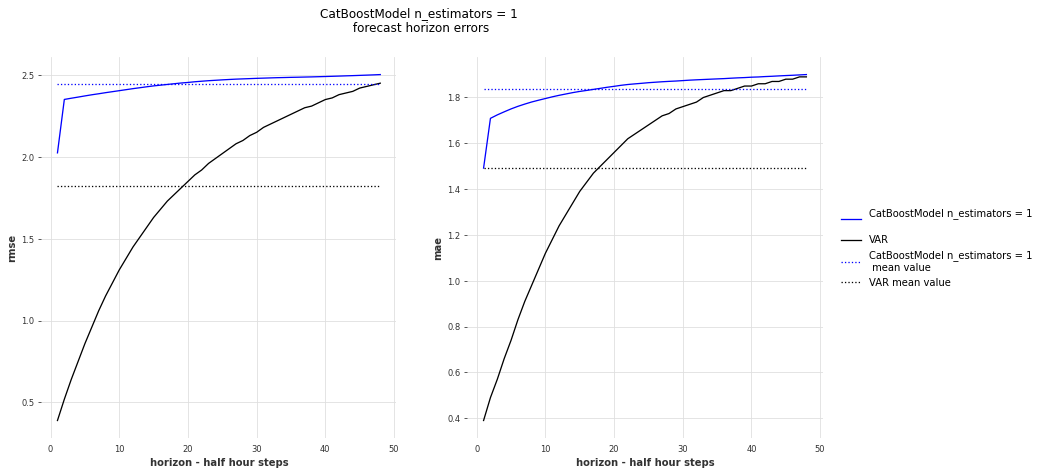

100%|██████████| 17263/17263 [17:29<00:00, 16.46it/s]


Backtest RMSE all: 1.781504
Backtest MAE all:  1.187082

# Backtest RMSE 48th: 1.827069
# Backtest MAE 48th:  1.208621

Backtest RMSE miss==0: 1.756549
Backtest MAE miss==0:  1.172214

Backtest RMSE miss==1: 3.558259
Backtest MAE miss==1:  2.784767


backtest['y_des']:
count	 801696
mean	 -0.577147
std	 2.089072
min	 -5.030532
25%	 -1.993525
50%	 -0.209447
75%	 1.296532
max	 5.679267


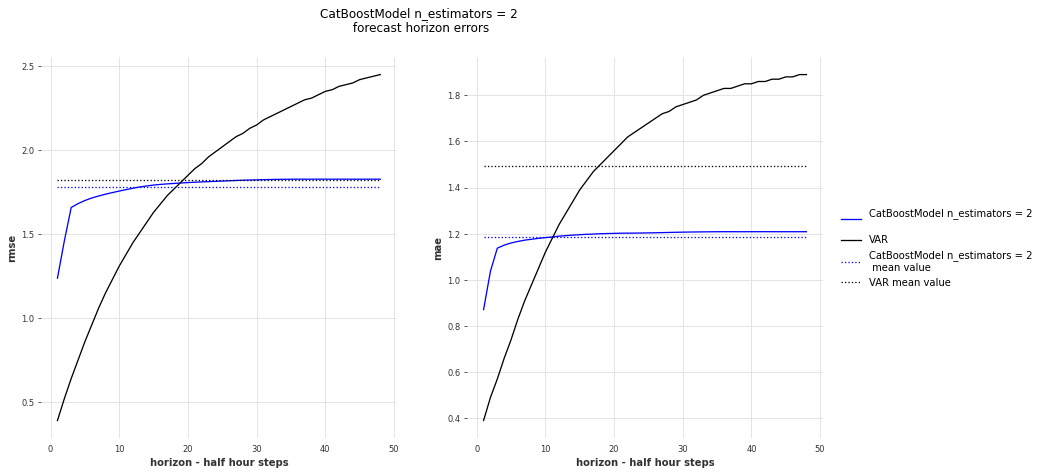

In [ ]:
for n_est in [1, 2]:
  model3 = CatBoostModel(lags = 1,
                         lags_past_covariates = 1,
                         n_estimators = n_est,
                        )

  model3.fit(series, 
             past_covariates = past_cov,
             val_series = val_ser,
             val_past_covariates = val_past_cov)
  backtest3 = model3.historical_forecasts(series = val_ser, 
                                          past_covariates = val_past_cov,
                                          start   = 0.01, 
                                          retrain = False,
                                          verbose = True, 
                                          forecast_horizon = HORIZON,
                                          last_points_only = False)

  hist_comp3 = calculate_historic_comparison(backtest3, valid_df)
  summarise_hist_comp(hist_comp3, valid_df)
  title3 = 'CatBoostModel n_estimators = ' + str(n_est) + '\n'
  plot_horizon_metrics(hist_comp3, title3)
  print("\n\n")


# Default starting model above
# Backtest RMSE 48th: 0.659983
# Backtest MAE 48th:  0.451157
# Clearly overfitting

# max_depth   = 2,
# l2_leaf_reg = 5,
# Backtest RMSE 48th: 0.720456
# Backtest MAE 48th:  0.492479
# Still clearly overfitting

# max_depth    = 2,
# l2_leaf_reg  = 5,
# n_estimators = 200,
# Backtest RMSE 48th: 0.798144
# Backtest MAE 48th:  0.554892
# Still clearly overfitting

# max_depth    = 2,
# l2_leaf_reg  = 10,
# n_estimators = 100,
# Backtest RMSE 48th: 1.135996
# Backtest MAE 48th:  0.766384
# Still clearly overfitting despite much higher metrics

# max_depth    = 2,
# l2_leaf_reg  = 10,
# n_estimators = 50,
# Backtest RMSE 48th: 1.873379
# Backtest MAE 48th:  1.319863
# Higher mean rmse and mae but still flat!

# max_depth    = 1,
# l2_leaf_reg  = 20,
# n_estimators = 200,
# Backtest RMSE 48th: 1.017505
# Backtest MAE 48th:  0.695825
# Still very flat :-(


# max_depth    = 10,
# l2_leaf_reg  = 20,
# n_estimators = 200,
# Backtest RMSE 48th: 0.664518
# Backtest MAE 48th:  0.454226
# Flat :-(

# max_depth    = 10,
# l2_leaf_reg  = 200,
# n_estimators = 200,
# Backtest RMSE 48th: 0.679561
# Backtest MAE 48th:  0.464022


# l2_leaf_reg  = 200,
# Backtest RMSE 48th: 0.664198
# Backtest MAE 48th:  0.448039
# Flat

# l2_leaf_reg  = 2000,
# Backtest RMSE 48th: 0.681874
# Backtest MAE 48th:  0.464827
# Flat

# n_estimators = 2,
# Backtest RMSE 48th: 1.827069
# Backtest MAE 48th:  1.208621
# Little bit less flat
# VAR mean value and CatBoostModel mean value are close (CatBoostModel is lower)
# Probably the model that is most comparable to VAR/lightgbm

# n_estimators = 1,
# Backtest RMSE 48th: 2.502509
# Backtest MAE 48th:  1.900066
# Entirely above the VAR model

# max_depth    = 3,
# l2_leaf_reg  = 10,
# n_estimators = 2,
# Backtest RMSE 48th: 3.50903
# Backtest MAE 48th:  2.730899
# Way above the VAR model and very flat

# l2_leaf_reg  = 10,
# n_estimators = 2,
# Backtest RMSE 48th: 3.435778
# Backtest MAE 48th:  2.662379
# Way above the VAR model and very flat



When `n_estimators` = 1 the forecast horizon is entirely above the VAR model for both mse and mae.

When `n_estimators` = 2 the mean of the mse across the horizon values is similar to the mean for the VAR model.

The flatness of the forecast horizons persists for both of the extremely low `n_estimators` values (mse and mae).

No point plotting learning curves when there are only 1 or 2 estimators (iterations).

---

Another parameter to regularise catboost models is `max_depth` which is the depth of trees built (default value 6). See [catboost docs](https://catboost.ai/en/docs/references/training-parameters/common#depth) for further details.

Here I try two low values for `max_depth`: 1 and 2.

100%|██████████| 17263/17263 [16:56<00:00, 16.98it/s]


Backtest RMSE all: 1.147094
Backtest MAE all:  0.838029

# Backtest RMSE 48th: 1.209437
# Backtest MAE 48th:  0.899289

Backtest RMSE miss==0: 1.141919
Backtest MAE miss==0:  0.836474

Backtest RMSE miss==1: 1.608981
Backtest MAE miss==1:  1.005134


backtest['y_des']:
count	 801696
mean	 -0.416003
std	 3.436016
min	 -9.512902
25%	 -2.481409
50%	 -0.692695
75%	 1.627042
max	 10.013161


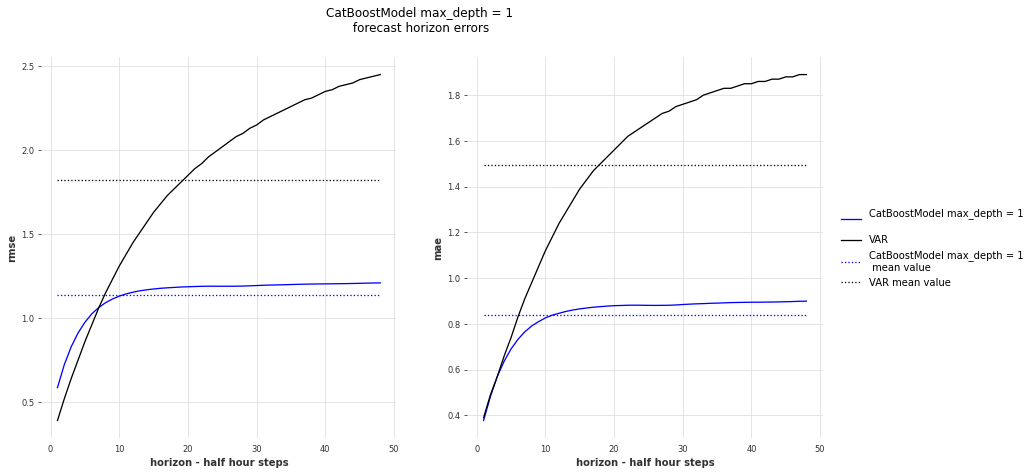

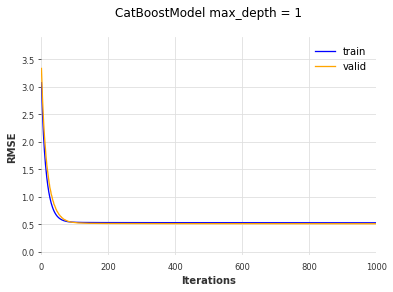

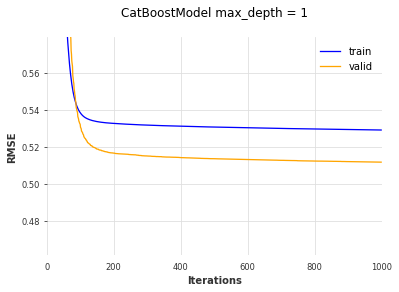

100%|██████████| 17263/17263 [17:04<00:00, 16.85it/s]


Backtest RMSE all: 0.779221
Backtest MAE all:  0.548126

# Backtest RMSE 48th: 0.787947
# Backtest MAE 48th:  0.55725

Backtest RMSE miss==0: 0.770323
Backtest MAE miss==0:  0.545478

Backtest RMSE miss==1: 1.445225
Backtest MAE miss==1:  0.83262


backtest['y_des']:
count	 801696
mean	 -0.390749
std	 3.423722
min	 -9.99258
25%	 -2.528091
50%	 -0.377385
75%	 1.708781
max	 10.355092


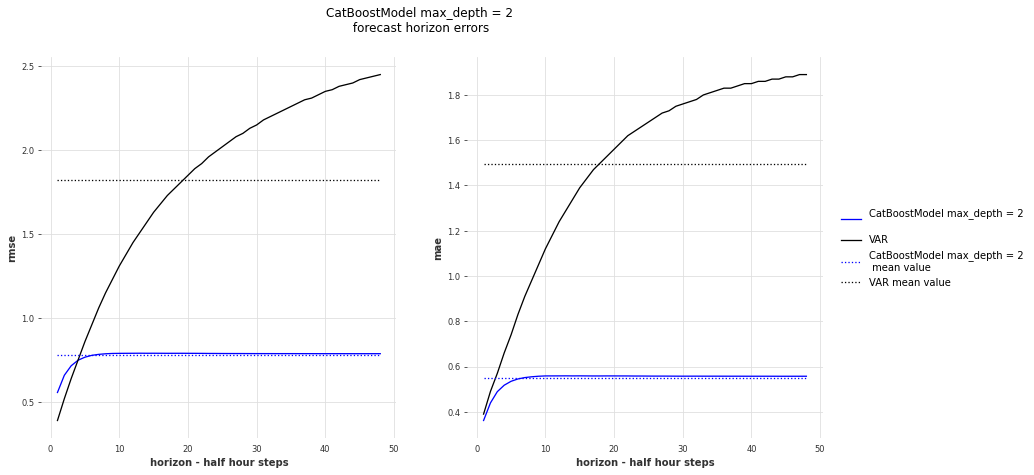

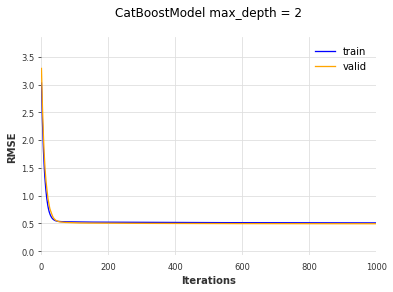

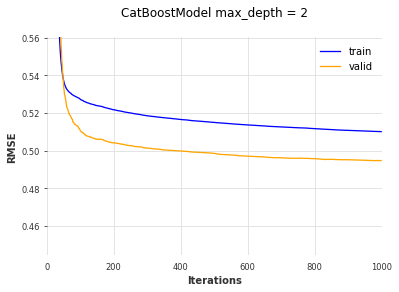

In [ ]:
for max_d in [1, 2]:
  model4 = CatBoostModel(lags = 1,
                         lags_past_covariates = 1,
                         max_depth = max_d,
                        )

  model4.fit(series, 
             past_covariates = past_cov,
             val_series = val_ser,
             val_past_covariates = val_past_cov)
  backtest4 = model4.historical_forecasts(series = val_ser, 
                                          past_covariates = val_past_cov,
                                          start   = 0.01, 
                                          retrain = False,
                                          verbose = True, 
                                          forecast_horizon = HORIZON,
                                          last_points_only = False)

  hist_comp4 = calculate_historic_comparison(backtest4, valid_df)
  summarise_hist_comp(hist_comp4, valid_df)
  title4 = 'CatBoostModel max_depth = ' + str(max_d) + '\n'
  plot_horizon_metrics(hist_comp4, title4)
  plot_learning_curve(model4, title4)
  plot_learning_curve(model4, title4, margin = 0.05)
  print("\n\n")

When `max_depth` equals 1 or 2 the forecast horizon is entirely below the VAR model but substantially above the initial catboost model for both mse and mae.

When `max_depth` = 1 the forecast horizon looks more reasonable for both mse and mae.

When `max_depth` = 2 the forecast horizon is again unrealisticaly flat.

Both learning curves look reasonable.

I don't show it here, but I also increased the `l2_leaf_reg` parameter.  It had a much smaller regularising effect.  See here for the relevant [catboost docs](https://catboost.ai/en/docs/references/training-parameters/common#l2_leaf_reg).

---

I briefly tried minimising `n_estimators` and `max_depth` together.

Here I show:
 * `n_estimators` 100
 * `max_depth` 4

100%|██████████| 17263/17263 [17:11<00:00, 16.74it/s]


Backtest RMSE all: 1.20218
Backtest MAE all:  0.851847

# Backtest RMSE 48th: 1.2652
# Backtest MAE 48th:  0.905113

Backtest RMSE miss==0: 1.191444
Backtest MAE miss==0:  0.846191

Backtest RMSE miss==1: 2.051018
Backtest MAE miss==1:  1.459587


backtest['y_des']:
count	 801696
mean	 -0.46144
std	 3.275178
min	 -10.945694
25%	 -2.549192
50%	 -0.456003
75%	 1.727668
max	 10.753087


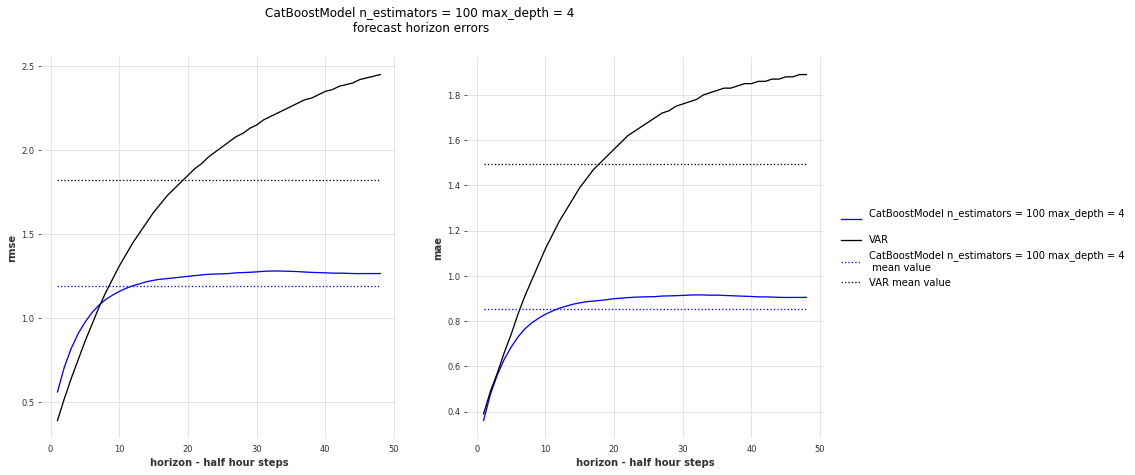

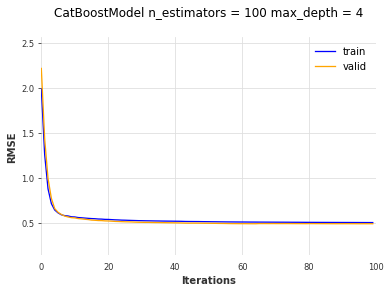

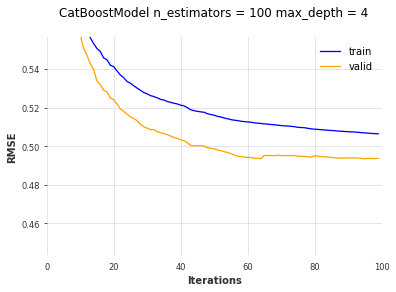

In [ ]:
n_est = 100
md    = 4

model6 = CatBoostModel(lags = 1,
                       lags_past_covariates = 1,
                       n_estimators = n_est,
                       max_depth    = md)

model6.fit(series, 
           past_covariates = past_cov,
           val_series = val_ser,
           val_past_covariates = val_past_cov)
backtest6 = model6.historical_forecasts(series = val_ser, 
                                        past_covariates = val_past_cov,
                                        start   = 0.01, 
                                        retrain = False,
                                        verbose = True, 
                                        forecast_horizon = HORIZON,
                                        last_points_only = False)

hist_comp6 = calculate_historic_comparison(backtest6, valid_df)
summarise_hist_comp(hist_comp6, valid_df)
title6 = 'CatBoostModel n_estimators = ' + str(n_est) + \
         ' max_depth = ' + str(md) + '\n'
plot_horizon_metrics(hist_comp6, title6)
plot_learning_curve(model6, title6)
plot_learning_curve(model6, title6, margin=0.05)

This is a large reduction in the number of catboost parameters.  Capacity for overfitting should be greatly reduced but it may not be entirely eliminated.  The learning curve looks reasonable.  The obvious overfitting has been eliminated.  It may be possible to further optimise the catboost models.

---

Next, plot model diagnostics:

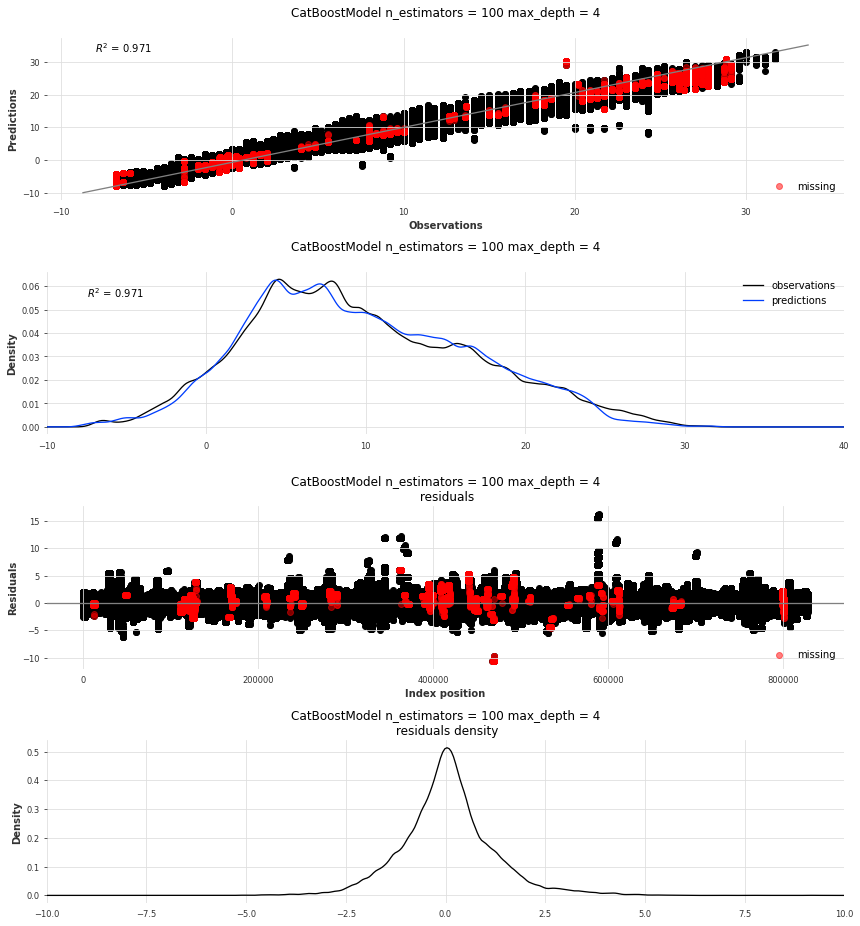

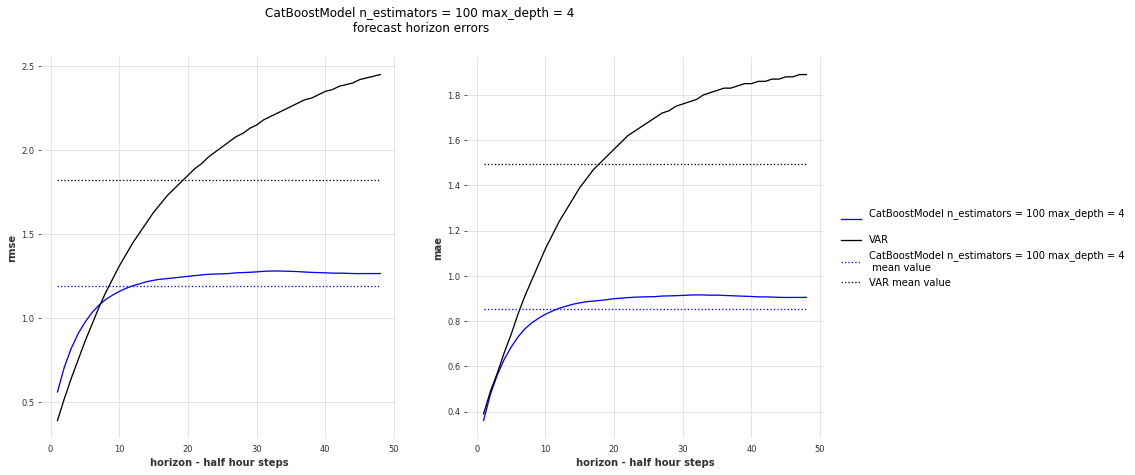

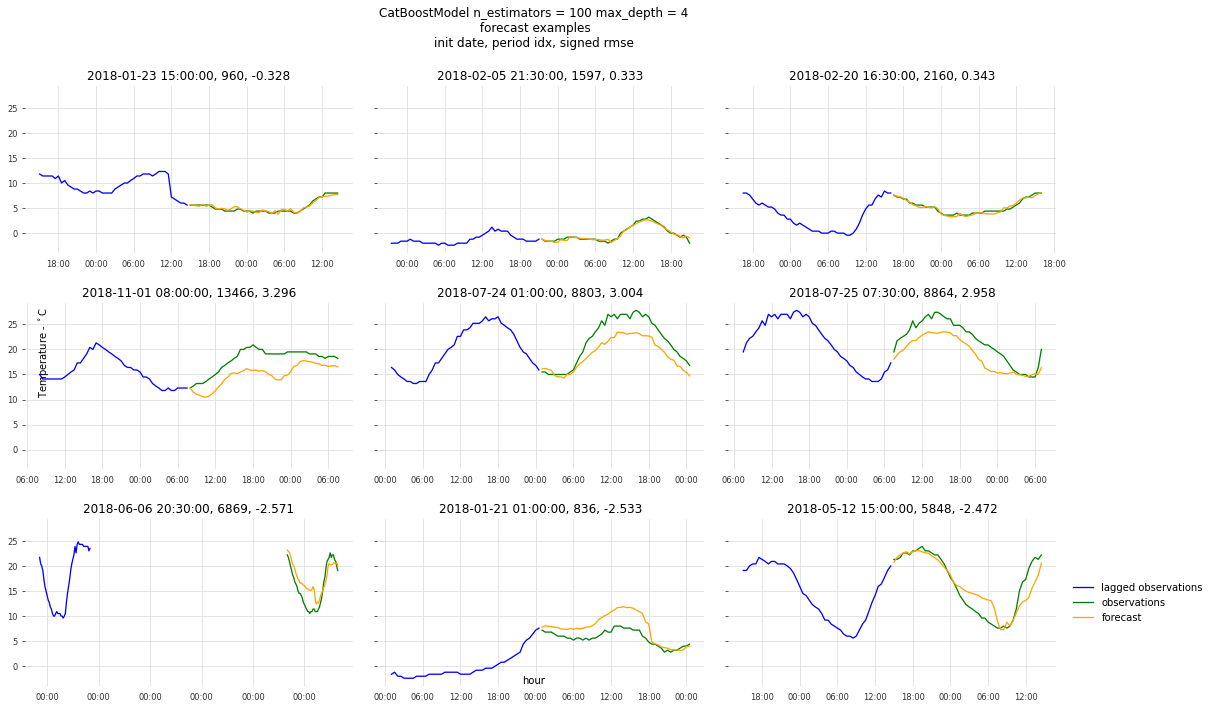

In [ ]:
plot_obs_vs_preds(hist_comp6, title6)
plot_obs_preds_dists(hist_comp6, title6)
plot_residuals(hist_comp6, title6 + ' residuals')
plot_residuals_dist(hist_comp6, title6 + ' residuals density')
plot_horizon_metrics(hist_comp6, title6)
plot_forecast_examples(hist_comp6, title6 + ' forecast examples')


The catboost model remains substantially better than the VAR and lightgbm models.

#### Lag selection

Not doing this

Explain why


---

#### Hyperparameter tuning 

Not doing this

Explain why


---


### Comparison with baselines

Finally, we can compare the best performing gradient boosted etc models against the best baseline method.  The VAR (Vector Auto-Regression) model from the [baselines notebook](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb) was the best performing baseline.

The best encoder decoder model, after 5 training epochs, was conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst.  Here I train the same model for 20 epochs.

Some points to note regarding the `plot_forecasts` diagnostic plot:
 * on validation data not test data
 * `plot_forecasts`
   * plot example forecasts with observations and lagged temperatures
      * first row shows examples of best near zero rmse forecasts
      * second row shows examples of worst positive rmse forecasts
      * third row shows examples of worst negative rmse forecasts
      * lagged observations are negative
      * the day of the year the forecast begins in and the rmse value is displayed above each sub-plot

test_df['y_des']:
count    17219.000000
mean        -0.600270
std          3.084216
min        -10.071429
25%         -2.723750
50%         -0.664286
75%          1.400000
max         12.292857
Name: y_des, dtype: float64



100%|██████████| 17263/17263 [17:03<00:00, 16.86it/s]


Backtest RMSE all: 1.091552
Backtest MAE all:  0.780597

# Backtest RMSE 48th: 1.148537
# Backtest MAE 48th:  0.827723

Backtest RMSE miss==0: 1.089392
Backtest MAE miss==0:  0.779557

Backtest RMSE miss==1: 1.434299
Backtest MAE miss==1:  0.971738


backtest['y_des']:
count	 815904
mean	 -0.603618
std	 2.813045
min	 -9.695111
25%	 -2.596343
50%	 -0.660294
75%	 1.358895
max	 11.027392


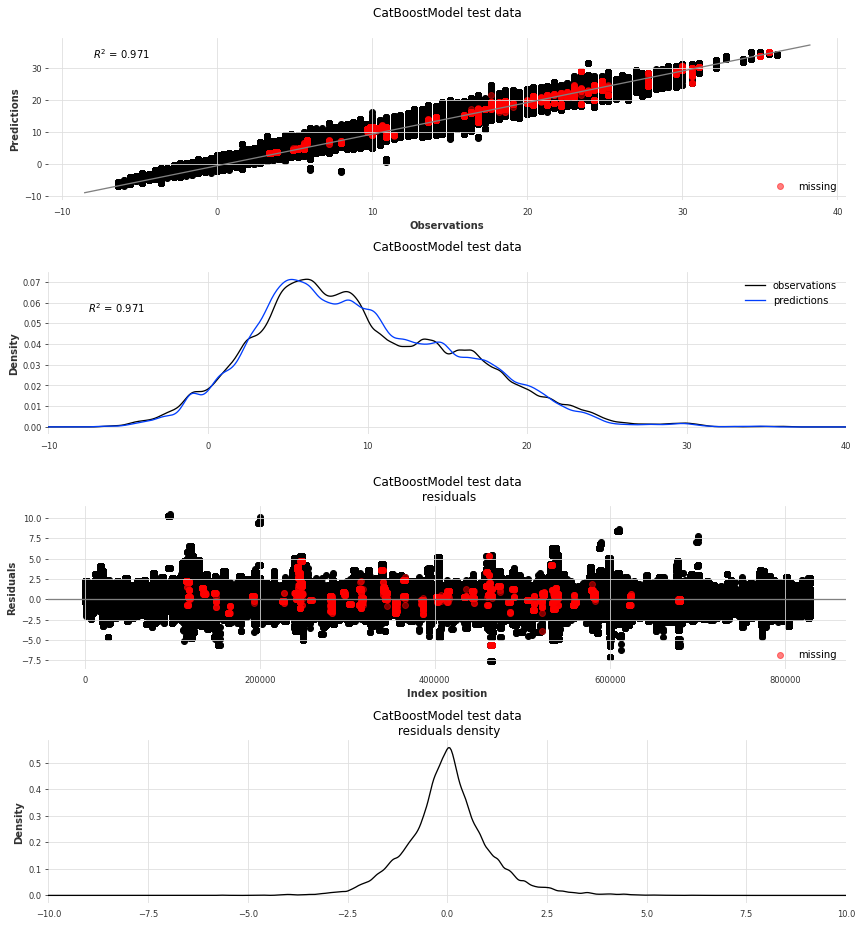

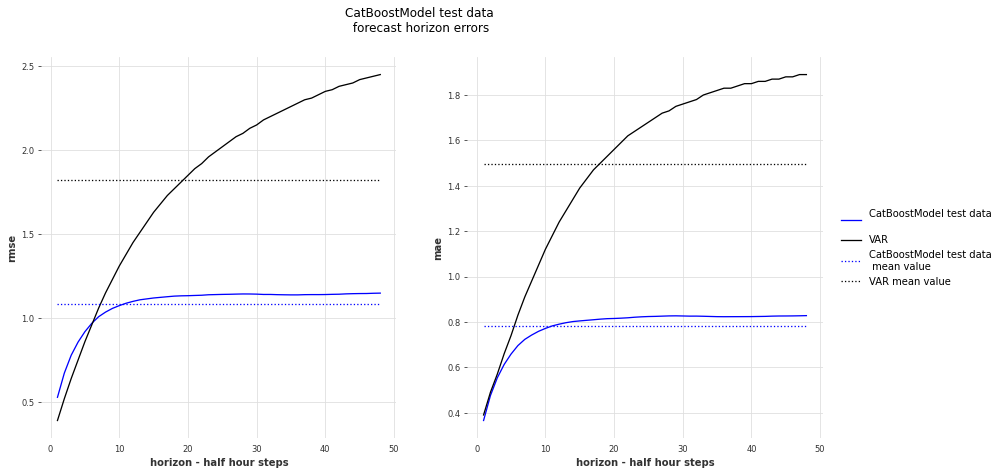

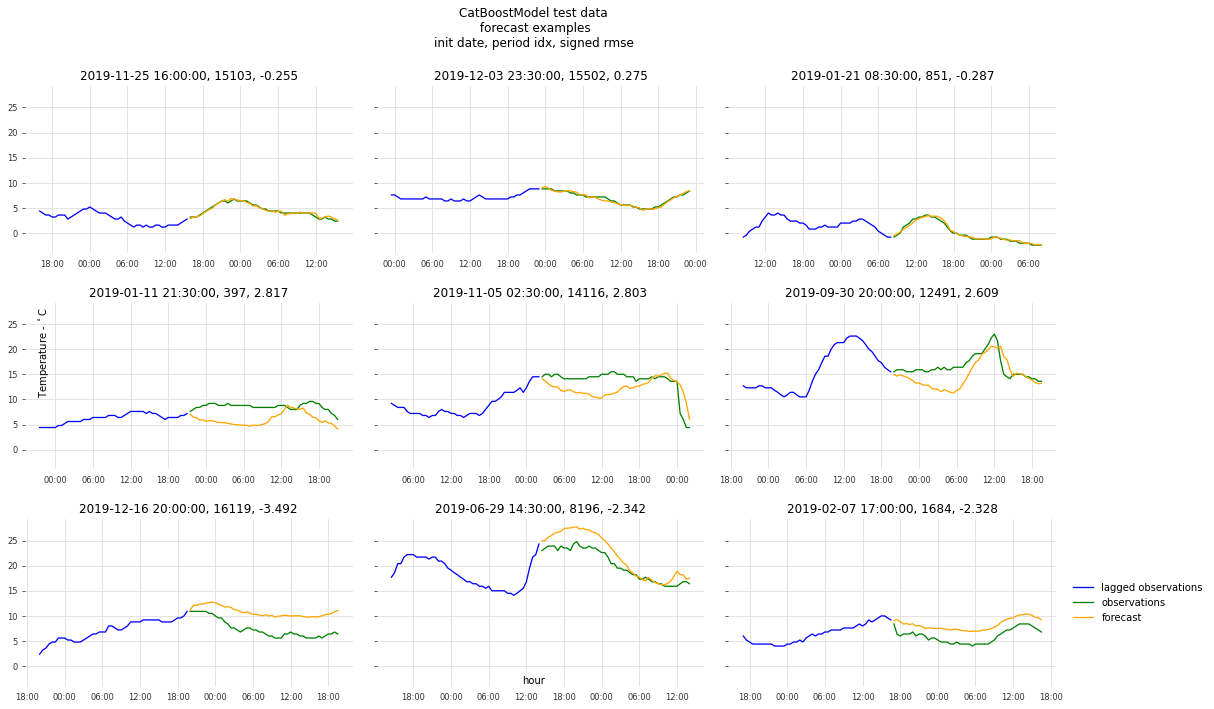

In [ ]:
test_ser = TimeSeries.from_dataframe(test_df, value_cols=Y_COL)
test_past_cov = TimeSeries.from_dataframe(test_df.loc[:, inc_cols['feature']])

print("test_df['", Y_COL, "']:\n", test_df[Y_COL].describe(), "\n", sep='')


n_est = 100
md    = 4

model7 = CatBoostModel(lags = 1,
                       lags_past_covariates = 1,
                       n_estimators = n_est,
                       max_depth    = md)

model7.fit(series, 
           past_covariates = past_cov,
           val_series = test_ser,
           val_past_covariates = test_past_cov)
backtest7 = model7.historical_forecasts(series = test_ser, 
                                       past_covariates = test_past_cov,
                                       start   = 0.01, 
                                       retrain = False,
                                       verbose = True, 
                                       forecast_horizon = HORIZON,
                                       last_points_only = False)

hist_comp7 = calculate_historic_comparison(backtest7, test_df)
summarise_hist_comp(hist_comp7, test_df)


title7 = 'CatBoostModel test data\n'
plot_obs_vs_preds(hist_comp7, title7)
plot_obs_preds_dists(hist_comp7, title7)
plot_residuals(hist_comp7, title7 + ' residuals')
plot_residuals_dist(hist_comp7, title7 + ' residuals density')
plot_horizon_metrics(hist_comp7, title7)
plot_forecast_examples(hist_comp7, title7 + ' forecast examples')

...

---

...

epochs : 20
Epoch 1/5
11759/11759 [==============================] - 13s 1ms/step - loss: 30942466.0000 - mae: 142.3176


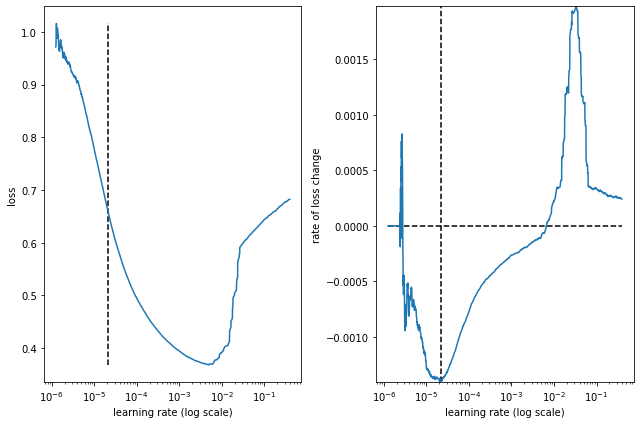

best lr: 2.1549979e-05 

Model: "conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 28, 10, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 10, 64)        512       
                                                                 
 flatten_2 (Flatten)         (None, 17920)             0         
                                                                 
 dense_6 (Dense)             (None, 448)               8028608   
                                                                 
 dense_7 (Dense)             (None, 224)               100576    
                                                                 
 dense_8 (Dense)             (None, 48)                10800     
                                                                 

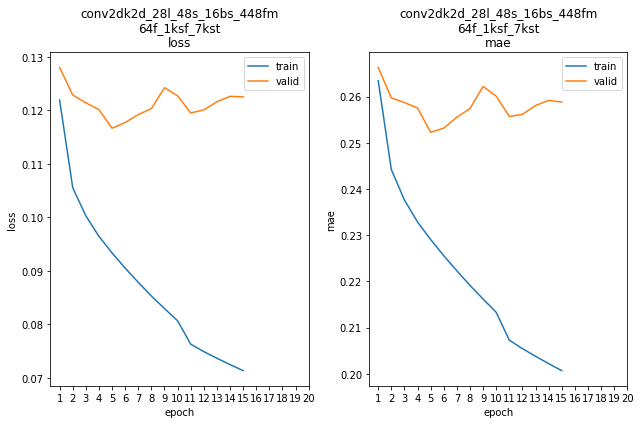

conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst train min loss: 0.071346	mae: 0.200707	epoch: 15
conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst valid min loss: 0.116655	mae: 0.252278	epoch: 5



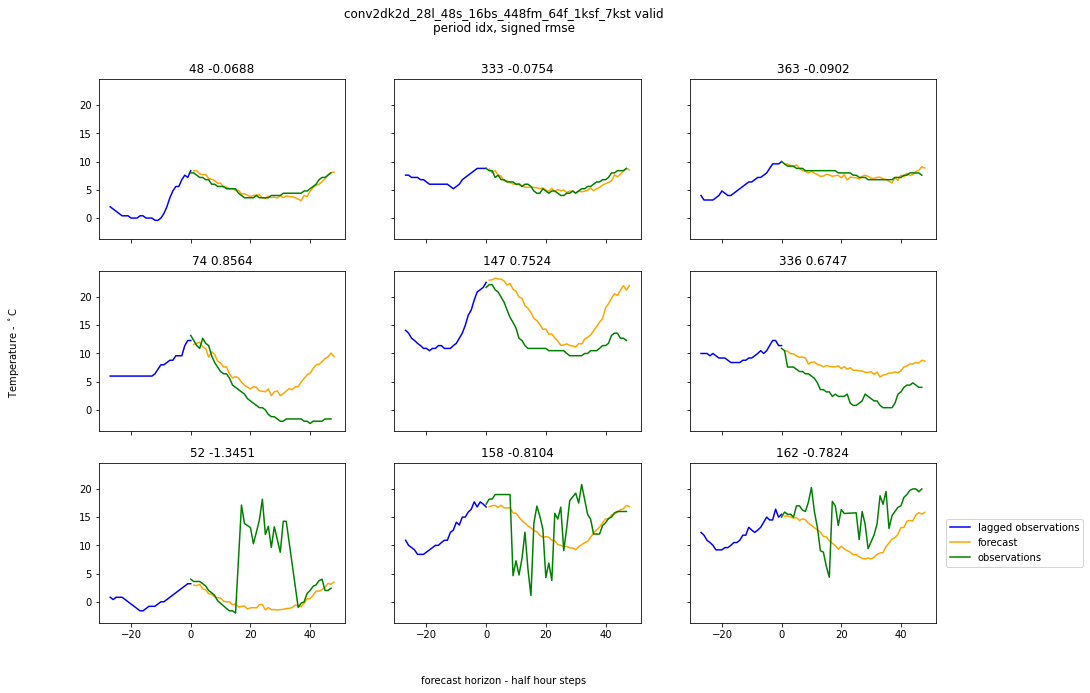

CPU times: user 20min 42s, sys: 3min 50s, total: 24min 32s
Wall time: 20min


In [ ]:
%%time


params = get_default_params('conv2dk2d')
params.update({'feat_maps':  448,
               'filters':     64,
               'lags':        28,
               'ks_feats':     1,
               'ks_time':      7,
               'lrf_params': [0.000001, 10, 32, 5, 100, 25]})
sweep_values = {'epochs': [20]}
models, epochs_model_names = sweep_param(models, params, sweep_values, verbose=True)

model_name = epochs_model_names[0]
plot_forecasts(models, model_name)

Results of the conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst model for 48 steps-ahead forecast after 20 epochs:

| CNN model             | params                         | mse     | mae     |
|-----------------------|--------------------------------|---------|---------|
|Conv2D Kern2D epochs= 5| lags=28, ks_feats=1, ks_time=7 | 0.11686 | 0.25261 |
|Conv2D Kern2D epochs=20| lags=28, ks_feats=1, ks_time=7 | 0.11665 | 0.25228 |

The model stopped training early after 15 epochs.  There was a marginal improvement in mse and mae.  As before, the minimal mse value was acheived at the 4th epoch.  The training plot shows some over-fitting.  Arguably, I should try the next best model but I doubt this will improve results by much.

Diagnostic plot summary:
 * once again, on validation data not test data
 * `plot_forecasts`
   * third row shows three highly suspect looking sets of observations for worst negative rmse forecast examples
   * clearly some remaining problem in the observations

---


Next, I plot the best Conv2D kernel 2D and VAR model rmse and mae values for forecast horizons up to 48 (24 hours, each horizon step is equivalent to 30 minutes).  This plot plus the two others are for forecasts on the previously unused 2019 "test" data.  This is different from the 2018 "validation" data used elsewhere in this notebook.

Some points to note regarding diagnostic plots:
 * once again, on test data not validation data
 * `plot_horizon_metrics`
   * plot rmse and mae values for each individual step-ahead
 * `check_residuals`
   * observations against predictions
   * residuals over time
   * residual distribution
 * `plot_forecasts`
   * see sub-section immediately above for notable points

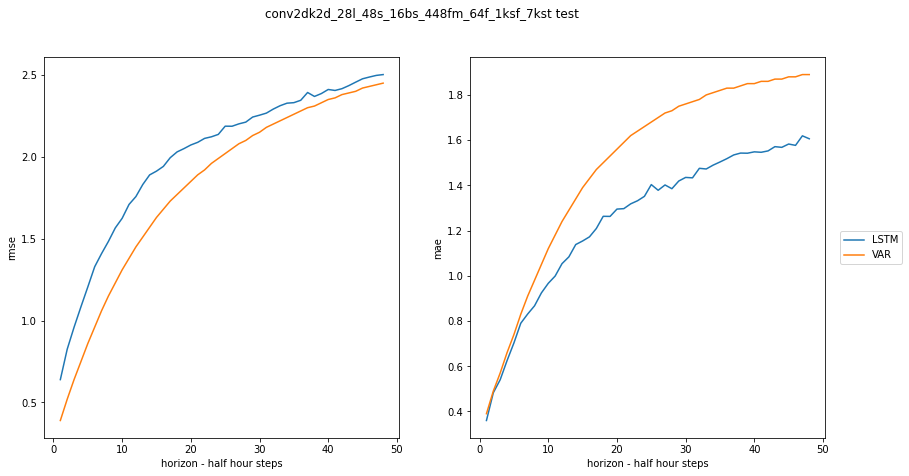

t rmse conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst: 2.057958616855633
t mae conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst:  1.179860027368246


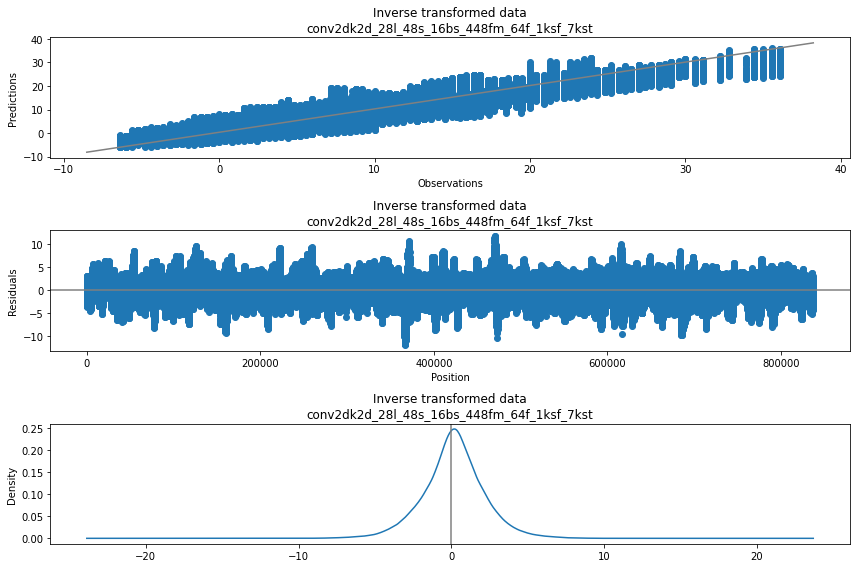

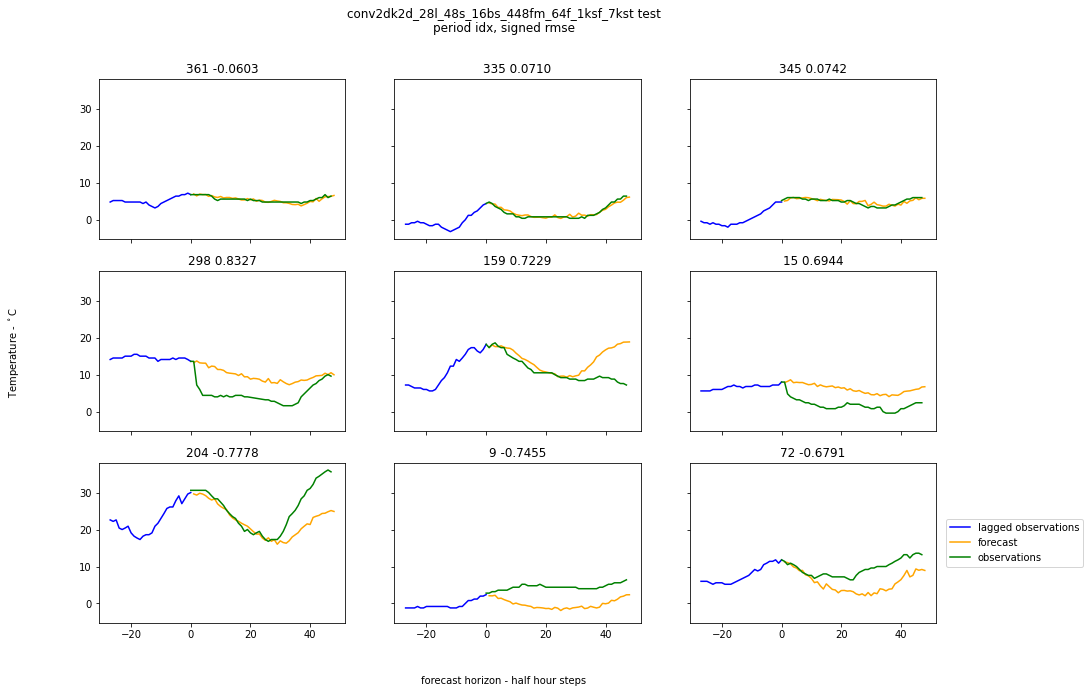

In [ ]:
ds = 'test'
best_mod = 'conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst'

plot_horizon_metrics(models, best_mod, dataset = ds)
check_residuals(models, best_mod, dataset = ds)
plot_forecasts(models, best_mod, dataset = ds)

Broadly speaking, these results are very similar to the results from the [best LSTM model](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb).


Diagnostic plots summary:
 * once again, these plots use test data not validation data
 * `plot_horizon_metrics`
   * initially, these results look quite contradictory
   * the rmse plot indicates better forecasts for the VAR method (in orange)
   * the mae plot indicates better forecasts for the Conv2D kernel 2D method (in blue, mis-labelled as LSTM)
 * `check_residuals`
   * the observations against predictions plot indicates
     * predictions are too high at cold temperatures (below 0 C) 
     * predictions are too low at hot temperatures (above 25 C)
   * residuals over time
     * no obvious heteroscadicity
     * no obvious periodicity
       * surprising given observations against predictions plot
   * residual distribution appears to be approximately normal (slightly right-skewed)
     * no obvious sign of fat tails
 * `plot_forecasts`
   * notable lack of noisy observations for the large positive and negative rmse examples

The median absolute error (mae) is less sensitive to outliers compared to the root mean squared error (rmse) metric.

Therefore, the rmse and mae plot difference may be due to the presence of outliers. I have maintained from the start that this data set is quite noisy, and attempts to correct these problems may have unintensionally introduced new issues.

Transformed mean values across the 48 step horizon:
 * rmse of 2.05796
 * mae of 1.17986

---


## Conclusion

The best results from the gradient boosted trees are similar/different to  results from the [best LSTM model](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb).

How and why are they similar/different?

Why are catboost models so much better than lightgbm models?

...

The conclusion is separated into the following sections:
 1. What worked
 2. What didn't work
 3. Rejected ideas
 4. Future work

The commit history for
 * [gradient_boosting.ipynb](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/commits/main/notebooks/gradient_boosting.ipynb)
 * [tsfresh_feature_engineering.ipynb](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/tsfresh_feature_engineering.ipynb)

provides details for the points summarised below.

1. What worked:
   * darts framework
   * lightgbm and catboost
     * variable importance was particularly useful
   * switching to forecasting deseasonalised temperature instead of temperature
   * adding solar irradiance
   * missing data annotation
     * particularly `missing` feature for plots
     * and `mi_filled` (multiple imputation filled) feature for models
        * perhaps this indicates the multiple imputation is problematic
     * `hist_average` (historic average) also appeared in a few models
        * again this may indicate problems
   * lags and past covariate lags
   * Borota-style shadow variables for feature selection
   * decomposing temperature, humidity and dew.point
      * using simple daily mean plus residuals

2. What didn't work:
 * [sktime](https://www.sktime.org/) framework
 * future covariates
    * I checked sinusoidal and spline-based time components
    * I did not check solar irradiance
 * spline-based time components
 * higher frequency sinusoidal time components
 * phase-shifted sinusoidal time components
 * calculating mixing ratio and absolute humidity
    * both have high correlation with dew point
       * absolute humidity 0.962
       * mixing ratio 0.96
 * smoothing humidity with simple moving average
 * using darts [RegressionModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html) with lightGBM instead of [lightGBMModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.gradient_boosted_model.html#darts.models.forecasting.gradient_boosted_model.LightGBMModel.historical_forecasts)
    * much better results with darts builtin lightGBMModel
    * however, it would be interesting to re-run some of the sk-learn models through darts RegressionModel with optimised lags, variable selection etc
 * using darts [RandomForest](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.random_forest.html)
    * too slow
 * tsfresh features
    * some subset of these features may be useful
    * see also: Conclusion in the [tsfresh_feature_engineering.ipynb](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/tsfresh_feature_engineering.ipynb) notebook
 * temperature statistical features
    * rolling mean and standard deviations over 6, 12 and 48 step windows
 * [shap.Explainer](https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html) with lightgbm model ran out of RAM and crashed after running for 2 hours
 * add confidence intervals to rmse and mae horizon plots
    * it's not immediately how to calculate CIs for rmse and mae
        * some discussion here: [Confidence interval of RMSE](https://stats.stackexchange.com/questions/78079/confidence-interval-of-rmse)
    * I am not going to consider bootstrapping CIs
 * mixup
    * darts TimeSeries requires `freq` be specified
    * won't work with irregularly time spaced mixup data augmentation
 * exact order to optimise parameters in remains unclear
    * feature selection
    * lag selection
    * hyperparameters
    * regularisation parameters _later_ on (best performing models only)
 * decomposing pressure, wind.x and wind.y
    * using simple daily mean plus residuals


3. Rejected ideas:
 * [El Niño–Southern Oscillation](https://en.wikipedia.org/wiki/El_Ni%C3%B1o%E2%80%93Southern_Oscillation)
    * might make sense if you live on the western coast of South America or a pacific island
    * there are many alternative [climate oscillations](https://en.wikipedia.org/wiki/Category:Climate_oscillations) and [regional climate effects](https://en.wikipedia.org/wiki/Category:Regional_climate_effects) that likely interact in non-trivial ways
    * having said that the [North Atlantic Oscillation](https://en.wikipedia.org/wiki/North_Atlantic_oscillation) affects on European temperatures may be a reasonable place to start a quick literature review
 * [calculating wind chill index](https://en.wikipedia.org/wiki/Wind_chill#North_American_and_United_Kingdom_wind_chill_index)
    * makes sense for electricity load forecasting but not for temperature forecasting
 * using [zenith delay signal](https://satellite-navigation.springeropen.com/articles/10.1186/s43020-021-00052-0) (ZTD) from the Global Navigation Satellite System ([GNSS](https://en.wikipedia.org/wiki/GNSS_applications)) signal to calculate [Precipitable Water Vapor](https://en.wikipedia.org/wiki/Precipitable_water) (PWV)
    * zenith delay signal is a measure of how much GNSS signals are affected by atmospheric refraction
    * precipitable water vapor is an important meteorological parameter for rainfall prediction
    * See: [Long-Term Rainfall Forecast Model Based on TheTabNet and LightGbm Algorithm](https://www.researchsquare.com/article/rs-107107/v1)
       * combine  pressure,  latitude,  height  of  weather  station into  ZTD feature, and combine date, height of the  station and ZTD into PWV feature


4. Future work:
 * reconsider using the rainfall observations
    * rainfall could work quite well with solar irradiance 
    * previously excluded due to noise though
 * use the temperature, dew point and relative humidity approximations to fill missing values instead of imputation, historic values etc
    * not just for the case where a single one of these variables are missing
    * hopefully will improve multiple imputation and historic averages issues
 * consider using [zenith angle](https://en.wikipedia.org/wiki/Solar_zenith_angle)
    * first check if subsumed by solar irradiance  
 * seasonal components
    * investigate one-hot encoded month variables
    * decompose temperature, humidity and dew point
      * instead of simple daily mean plus residuals
      * [Seasonal-Trend decomposition using LOESS](https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html)
      * [unobserved components](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_structural_harvey_jaeger.html)
    * decompose pressure, wind.x and wind.y
      * instead of simple daily mean plus residuals
      * [SSA](https://en.wikipedia.org/wiki/Singular_spectrum_analysis), [DMD](https://en.wikipedia.org/wiki/Dynamic_mode_decomposition), [wavelets](https://en.wikipedia.org/wiki/Daubechies_wavelet), [VMD](https://github.com/vrcarva/vmdpy) etc
 * check denoising
    * for example [total variation denoising for signals](https://contrib.scikit-learn.org/lightning/auto_examples/plot_1d_total_variation.html)
      * note, not total variation for images
      * unlike moving averages total variation acts as an [edge-preserving filter](https://en.wikipedia.org/wiki/Edge-preserving_smoothing)
      * see also [1D-MCTV-Denoising](https://github.com/MrCredulous/1D-MCTV-Denoising)
    * many other methods to choose between
 * variable selection
    * calculate [Shapley values](https://en.wikipedia.org/wiki/Shapley_value) for each feature
    * on a subset of the training data to reduce compute time
       * hope to avoid earlier mentioned shap.Explainer problems
 * automate lag selection
 * observation selection
    * approximate the 'value' of each observation using 'data Shapley values'
    * again compute time could be a problem
    * [Data Shapley: equitable valuation of data for machine learning](http://proceedings.mlr.press/v97/ghorbani19c/ghorbani19c.pdf)
    * [Adrian Colyer's summary](https://blog.acolyer.org/2019/07/15/data-shapley/)
    * alternatively, consider exluding some of the older data
        * some of this data was gathered with older sensors now replaced
 * feature engineering
    * tsfresh 
      * explore feature selection with recursive elimination and/or recursive addition
      * try shorter and longer lagged windows - 12, 24, 96, 144
      * consider repeating without `mi_filled == 1` and `hist_average == 1`
      * consider repeating on a subset of non-seasonal, non-cyclic decomposed time series
    * investigate [tsfeatures](https://github.com/Nixtla/tsfeatures)
 * use lightgbm/catboost to generate new features for use with other forecast methods
    * first introduced by facebook in [Practical Lessons from Predicting Clicks on Ads at
Facebook](http://quinonero.net/Publications/predicting-clicks-facebook.pdf)
    * effectively uses lightgbm/catboost as a feature transform
    * each element of the new feature vector corresponds to a leaf node from one of the trees in the boosting model
    * the length of the new feature vector is equal to the sum of the number of leaf nodes contained in all trees in the boosting model
    * you can use `predict(..., pred_leaf=True`), or similar option, to get the leaf_Index of each sample on each tree
    * then one-hot encode the result
    * see also: [The principle and practice of RF, GBDT and Xgboost constructing new features](https://blog.csdn.net/anshuai_aw1/article/details/82983997)
 * cross-validation
    * switch to 10-fold cross-validation
    * big increase in computation time :-(
 * data augmentation
    * explore range blending from [Forecasting with gradient boosted trees: augmentation, tuning, and cross-validation strategies: Winning solution to the M5 Uncertainty competition](https://www.sciencedirect.com/science/article/pii/S0169207021002090) with temperature, dew point and relative humidity approximation formulas
      * assume zero wind
    * randomly apply
      * randomly swap 2 observation rows
      * randomly delete observation rows
      * randomly insert observation rows
      * randomly replace observation rows with similar rows
 * add more diagnostic plots
    * residuals autocorrelation function
 * explore alternative time series forecasting frameworks
      * check [skforecast](https://github.com/JoaquinAmatRodrigo/skforecast) for multi-variate support
      * [GluonTS](https://ts.gluon.ai/stable/)
      * the [Nixtla](https://github.com/Nixtla) group have several interesting packages
         * [statsforecast](https://github.com/Nixtla/statsforecast)
         * [mlforecast](https://github.com/Nixtla/mlforecast)
         * [neuralforecast](https://github.com/Nixtla/neuralforecast)
      * it's probably safe to [ignore AWS forecast for a while](https://github.com/Nixtla/statsforecast/tree/main/experiments/amazon_forecast) lol :-)



---

## Metadata

Python and Jupyter versions plus modules imported and their version strings. 
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer. 
There are simpler alternatives, such as watermark, but they all require installation.

In [ ]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

Python version:
/usr/bin/python3
3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

IPython version:
5.5.0


In [ ]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

Imported modules:


name,version
seaborn,0.11.2
scikit-learn,1.0.2
pandas,1.3.5
numpy,1.21.6
matplotlib,3.2.2
keras,2.10.0


In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:            3
CPU MHz:             2000.178
BogoMIPS:            4000.35
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            39424K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_si

In [ ]:
!date

Sat Jun 18 14:10:54 UTC 2022


---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

Notebook name is hardcoded below because the alternative is ghastly globs of unreliable javascript or external ipython libraries I'd prefer to avoid installing :-(

In [ ]:
from time import sleep

notebook = "gradient_boosting.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}